In [1]:
import numpy as np

import scipy.io
import scipy.stats

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 

import itertools

#extend notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:99.5% !important;} </style>"))

# from tslearn.metrics import dtw as time_warping

import ordpy
import tqdm
import igraph
import string

from numpy import linalg as LA
from scipy.signal import find_peaks

In [2]:
#Statistical Learning
from sklearn.cluster import KMeans

#model selectionfrom sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import validation_curve
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import cross_val_score

#evaluation
# from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import silhouette_score

#dimensionality reduction
from sklearn.decomposition import PCA

# Functions' definitions

In [3]:
def stdfigsize(scale=1, nrows=1, ncols=1, ratio=1.3):
    """
    Returns a tuple to be used as figure size.

    Parameters
    ----------
    returns (7*ratio*scale*nrows, 7.*scale*ncols)
    By default: ratio=1.3
    ----------
    Returns (7*ratio*scale*nrows, 7.*scale*ncols).
    """

    return((7*ratio*scale*ncols, 7.*scale*nrows))

In [4]:
%matplotlib inline

#Style definitions
sns.set_style("white")
sns.set_style({"xtick.direction": "out", "ytick.direction": "out"})

rcparams = {
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica'],
    'axes.labelsize': 28,
    'axes.titlesize': 28,
    'legend.fontsize': 20,
    'ytick.right': 'off',
    'xtick.top': 'off',
    'ytick.left': 'on',
    'xtick.bottom': 'on',
    'xtick.labelsize': '25',
    'ytick.labelsize': '25',
    'axes.linewidth': 2.5,
    'xtick.major.width': 1.8,
    'xtick.minor.width': 1.8,
    'xtick.major.size': 14,
    'xtick.minor.size': 7,
    'xtick.major.pad': 10,
    'xtick.minor.pad': 10,
    'ytick.major.width': 1.8,
    'ytick.minor.width': 1.8,
    'ytick.major.size': 14,
    'ytick.minor.size': 7,
    'ytick.major.pad': 10,
    'ytick.minor.pad': 10,
    'axes.labelpad': 15,
    'axes.titlepad': 15,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'figure.figsize': stdfigsize(),
    'lines.linewidth': 3
}
mpl.rcParams.update(rcparams)

In [5]:
def normalize(array):
    """
    Normalizes an array between 0 and 1.
    """
    return (array-array.min())/(array.max()-array.min())

In [6]:
def full_ordinal_distribution(data, dx=3, taux=1, multi=False):
    """
    Ordinal probability distribution. Ordered and with 
    permutations with zero probability.
    
    Parameter
    ---------
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`.
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    multi : boolean
            If `True`, assumes **data** is multivariate time series. If 
            `False`, **data** is expected to be a one-dimensional 
            array (default: `False`). 
    ---------
     : tuple
       Tuple containing two arrays, one with the ordinal patterns occurring in data 
       and another with their corresponding probabilities.

    """
    if multi==False:
        try:
            ny, nx = np.shape(data)
            data   = np.array(data)
        except:
            nx     = np.shape(data)[0]
            ny     = 1
            data   = np.array([data])
            
        partitions = np.concatenate(
            [
                [np.concatenate(data[j:j+1:1,i:i+dx*taux:taux]) for i in range(nx-(dx-1)*taux)] 
                for j in range(ny)
            ]
        )

        symbols = np.apply_along_axis(np.argsort, 1, partitions)
        symbols, symbols_count = np.unique(symbols, return_counts=True, axis=0)

        probabilities = symbols_count/len(partitions)
        full_symbols  = np.asarray(list(itertools.permutations(np.arange(dx))))

        flat_symbols     = np.apply_along_axis(np.array2string, 1, symbols, separator='')
        full_symbols_str = np.apply_along_axis(np.array2string, 1, full_symbols, separator='')
        full_probs       = np.full(len(full_symbols), 0.)

        for symbol_, probs_ in zip(flat_symbols, probabilities):
            index             = np.argwhere(symbol_==full_symbols_str).flatten()
            full_probs[index] = probs_

        return full_symbols, full_probs
        
    else:
        try:
            ny, nx = np.shape(data)
            data   = np.array(data).T
        except:
            return None

        partitions                  = [np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data]
        flat_symbolic_sequences     = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
        flat_symbols, symbols_count = np.unique(flat_symbolic_sequences, return_counts=True, axis=0)

        probabilities = symbols_count/symbols_count.sum()
        full_symbols  = np.asarray(list(itertools.permutations(np.arange(dx))))

        flat_symbols     = np.apply_along_axis(np.array2string, 1, flat_symbols, separator='')
        full_symbols_str = np.apply_along_axis(np.array2string, 1, full_symbols, separator='')
        full_probs       = np.full(len(full_symbols), 0.)

        for symbol_, probs_ in zip(flat_symbols, probabilities):
            index             = np.argwhere(symbol_==full_symbols_str).flatten()
            full_probs[index] = probs_

        return full_symbols, full_probs

    
def fisher_shannon(data, dx=3, taux=1, probs=False, multi=False):
    """
    Calculates permutation entropy\\ [#bandt_pompe]_ and Fisher 
    information using an ordinal distribution obtained from data.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[x_{1}, x_{2}, x_{3}, \\ldots ,x_{n}]`
           or  :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]`
           or an ordinal probability distribution (such as the ones returned by 
           `full_ordinal_distribution`).
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    probs : boolean
            If `True`, assumes **data** is an ordinal probability distribution. If 
            `False`, **data** is expected to be a one- or two-dimensional 
            array (default: `False`). 
    multi : boolean
            If `True`, assumes **data** is multivariate time series. If 
            `False`, **data** is expected to be a one-dimensional 
            array (default: `False`). 

    Returns
    -------
     : tuple
       Values of permutation entropy and Fisher information.
    """  
    if multi==False:
        if probs==False:
            _, dist_ = full_ordinal_distribution(data, dx, taux)
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)
        else:
            dist_    = data
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)

        if dist_[0]==1. or dist_[-1]==1.: # F = F_0 \sum_{i = 1}^{N - 1} (\sqrt{p_{i+1}} - \sqrt{p_{i}})^2
            return h_, np.sum(np.diff(np.sqrt(dist_[::-1]))**2)  # with F_0=1
        else:
            return h_, 0.5*np.sum(np.diff(np.sqrt(dist_[::-1]))**2) # with F_0=1/2
        
    else:
        if probs==False:
            _, dist_ = full_ordinal_distribution(data, dx, taux, multi=True)
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)
        else:
            dist_    = data
            h_       = ordpy.permutation_entropy(dist_, dx, taux, probs=True)

        if dist_[0]==1. or dist_[-1]==1.: # F = F_0 \sum_{i = 1}^{N - 1} (\sqrt{p_{i+1}} - \sqrt{p_{i}})^2
            return h_, np.sum(np.diff(np.sqrt(dist_[::-1]))**2) # with F_0=1
        else:
            return h_, 0.5*np.sum(np.diff(np.sqrt(dist_[::-1]))**2) # with F_0=1/2

        
def multi_permutation_entropy(data, dx=3, taux=1, base=2, normalized=True, return_probs=False):
    """
    Calculates Shannon's entropy using an ordinal ditribution obtained from
    a multidimensional time series.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    try:
        ny, nx = np.shape(data)
        data   = np.array(data).T
    except:
        return None
    
    partitions                  = [np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data]
    flat_symbolic_sequences     = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    flat_symbols, symbols_count = np.unique(flat_symbolic_sequences, return_counts=True, axis=0)

    probabilities = symbols_count/symbols_count.sum()

    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))
        else:
            return -np.sum(probabilities*np.log(probabilities))

In [7]:
#first revised version in 19/01/2022. #second revision in 03/02/2022
def permutation_js_distance(data, dx=3, taux=1, base=2, normalized=True, tie_precision=None): #falta uma referência.
    """
    Calculates permutation Jensen-Shannon distance between multiple
    time series using an ordinal distribution obtained from data.
    
    Parameters
    ---------
    data : array
           Array object in the forma :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` representing an 
           m-dimensional time series of length n or m time series of length n.
           
    dx : int
         Embedding dimension (horizontal axis) (default: 3).
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 2).
    normalized: boolean
                If `True`, the permutation Jensen-Shannon distance is normalized by its 
                maximum value (default: `True`). If `False`, it is not.
    tie_precision : int
                    If not `None`, **data** is rounded with `tie_precision`
                    number of decimals (default: `None`).
                    
    Returns
    -------
     : float
       Value of normalized permutation entropy and statistical complexity.
       
    Examples
    --------
    """
    try:
        ny, nx = np.shape(data)
        data   = np.array(data).T
    except:
        return None

    if tie_precision is not None:
        data = np.round(data, tie_precision)
    
    if base=='e':
        log_function = np.log
    else:
        log_function = np.log2

    partitions         = [np.concatenate([[channel[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for channel in data]
    symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions)

    num_of_channels    = symbolic_sequences.shape[0]
    full_distributions = []
    sum_of_entropies   = 0.
    
    full_symbols     = np.unique(symbolic_sequences.reshape(-1, dx), axis=0)
    full_symbols_str = np.apply_along_axis(np.array2string, 1, full_symbols, separator='').flatten()

    for sequence_ in symbolic_sequences:
        symbols, symbols_count = np.unique(sequence_, return_counts=True, axis=0)
        probabilities          = symbols_count/symbols_count.sum()

        sum_of_entropies += -np.sum(probabilities*log_function(probabilities))/num_of_channels
        flat_symbols      = np.apply_along_axis(np.array2string, 1, symbols, separator='')
        full_probs        = np.full(len(full_symbols_str), 0.)

        for symbol_, probs_ in zip(flat_symbols, probabilities):
            index             = np.argwhere(symbol_==full_symbols_str).flatten()
            full_probs[index] = probs_

        full_distributions.append(full_probs)
    
    sum_of_distr   = np.sum(full_distributions, axis=0)/num_of_channels
    entropy_of_sum = -np.sum(sum_of_distr*log_function(sum_of_distr))
    
    difference     = entropy_of_sum - sum_of_entropies
    is_it_nan      = np.isnan(np.sqrt(difference))
    
    if is_it_nan==True: #added after having problems calculating the square root of negative numbers caused by floating point representation problems in Python.
        return 0
    else:
        if normalized==True:
            perm_js_max = log_function(num_of_channels)
            return np.sqrt(difference/perm_js_max)

        else:
            return np.sqrt(difference)

In [8]:
def new_plane(data, dx, base=2):
    """
    """
    h, c = multi_permutation_entropy(data, dx, base=base), permutation_js_distance(data, dx, base=base)
    
    return h, c

In [9]:
def mwpe(data, dx=3, taux=1, base=2, normalized=True, return_probs=False):
    """
    Multivariate weighted permutation entropy.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    try:
        ny, nx = np.shape(data)
        data   = np.array(data).T
    except:
        return None
    
    partitions              = np.asarray([np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data])
    weights                 = partitions.var(axis=2).flatten()
    flat_symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    symbols                 = np.unique(flat_symbolic_sequences, return_counts=False, axis=0)


    total_variance = []
    for symbol in symbols:
        z    = flat_symbolic_sequences==symbol
        z    = z.sum(axis=1)
        args = np.argwhere(z==dx).flatten()
        
        total_variance.append(sum(weights[args]))

    probabilities = total_variance/sum(total_variance)
    
    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))

        else:
            return -np.sum(probabilities*np.log(probabilities))   

In [10]:
def weighted_permutation_entropy(data, dx=3, taux=1, base=2, normalized=True):
    """
    Multivariate weighted permutation entropy.
    
    Parameters
    ----------
    data : array
           Array object in the format :math:`[[x_{11}, x_{12}, x_{13}, \\ldots, x_{1m}],
           \\ldots, [x_{n1}, x_{n2}, x_{n3}, \\ldots, x_{nm}]]` where n is the length 
           and m is the dimension of a multidimensional time series.
    dx : int
         Embedding dimension (horizontal axis) (default: 3)
    taux : int
           Embedding delay (horizontal axis) (default: 1).
    base : str, int
           Logarithm base in Shannon's entropy. Either 'e' or 2 (default: 'e').
    normalized: boolean
                If `True`, permutation entropy is normalized by its maximum value.
                If `False`, it does not (default: `True`).

    Returns
    -------
     : float
       The value of permutation entropy.
    
    Examples
    --------
    """
    data   = np.asarray(data)
    
    partitions              = np.asarray([np.concatenate([[component[i:i+dx*taux:taux]] for i in range(ny-(dx-1)*taux)]) for component in data])
    weights                 = partitions.var(axis=2).flatten()
    flat_symbolic_sequences = np.apply_along_axis(np.argsort, 2, partitions).reshape(-1, dx)
    symbols                 = np.unique(flat_symbolic_sequences, return_counts=False, axis=0)


    total_variance = []
    for symbol in symbols:
        z    = flat_symbolic_sequences==symbol
        z    = z.sum(axis=1)
        args = np.argwhere(z==dx).flatten()
        
        total_variance.append(sum(weights[args]))

    probabilities = total_variance/sum(total_variance)
    
    if return_probs==True:
        miss_symbols  = np.math.factorial(dx)-len(probabilities)
        probabilities = np.concatenate((probabilities, np.zeros(miss_symbols)))
        
        return probabilities
    
    else:
        if normalized==True and base in [2, '2']:        
            smax = np.log2(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log2(probabilities))
            return s/smax

        elif normalized==True and base=='e':        
            smax = np.log(np.math.factorial(dx))
            s    = -np.sum(probabilities*np.log(probabilities))
            return s/smax

        elif normalized==False and base in [2, '2']:
            return -np.sum(probabilities*np.log2(probabilities))

        else:
            return -np.sum(probabilities*np.log(probabilities))   

In [11]:
def trajectory_cleaning(shape):
    """
    Cleans and segments the original trajectories of falling papers
    using the data and parameters established by Howison et al., 
    Nature Machine Intelligence 2, 68–75(2020).
    
    Parameters
    ----------
    shape (str): shape of falling paper. Either "Circle", 
                 "Square" or "Cross".
    ----------
    Returns several arrays or floats containing time series
    or characteristics of the falling papers:
    
    - series of tridimensional trajectories; 
    - series of observable area (camera 1); 
    - series of observable area (camera 2);
    - radii of falling paper shape;
    - width of falling paper shape (in case shape=="Cross");
    - initial condition (0 for robotic arm in horizontal position,
      1 for vertical position);
    - preclassification of cleaned trajectories (3 for periodic falling and nan 
    for possibly chaotic or tumbling time series).
                         
    References
    ----------
    Howison et al., Large-scale automated investigation of free-falling paper shapes 
    via physical experimentation, Nature Machine Intelligence 2, 68–75 (2020).
    
    """
    ##########################################################################################
    #Data processing

    #Improving data structure. Extracting data from data{shape}.mat and loading it into data arrays
    disk_data = scipy.io.loadmat('classification/data{}.mat'.format(shape))

    #initial condition of the experiments: 0 (dropping with arm holding the paper horizontally) or 1 (dropping vertically)
    disk_initcons = []
    for i in range(len(disk_data['data'][0])):
        disk_initcons.append(disk_data['data'][0][i]['initialCondition'][0][0][0][0])
    disk_initcons = np.asarray(disk_initcons)

    # radii of the disks dropped
    disk_radii = []
    for i in range(len(disk_data['data'][0])):
        disk_radii.append(disk_data['data'][0][i]['radius'][0][0][0][0])
    disk_radii = np.asarray(disk_radii)

    # width of the crosses dropped
    if shape=='Cross':
        disk_width = []
        for i in range(len(disk_data['data'][0])):
            disk_width.append(disk_data['data'][0][i]['width'][0][0][0][0])
        disk_width = np.asarray(disk_width)

    # camera 1 observable area?
    disk_cam1 = []
    for i in range(len(disk_data['data'][0])):
        disk_cam1.append(disk_data['data'][0][i]['areaCam1'][0][0].flatten())
    disk_cam1 = np.asarray(disk_cam1)

    # camera 2 observable area?
    disk_cam2 = []
    for i in range(len(disk_data['data'][0])):
        disk_cam2.append(disk_data['data'][0][i]['areaCam2'][0][0].flatten())
    disk_cam2 = np.asarray(disk_cam2)

    # coordinates (x, y, z) along trajectory from 1m high to the floor.
    disk_trajectories = []
    for i in range(len(disk_data['data'][0])):
        disk_trajectories.append(disk_data['data'][0][i]['trajectory'][0][0])
    disk_trajectories = np.asarray(disk_trajectories)
    ##########################################################################################

    
    #Cleaning trajectories
    clean_disk_trajectories = []
    clean_disk_cam2         = []
    clean_disk_cam1         = []
    
    clean_disk_initcons     = []
    clean_disk_class        = []
    clean_disk_radii        = []
    clean_disk_width        = []

    for i in range(len(disk_trajectories)):
        #vertical trajectory
        z         = disk_trajectories[i][::,2][::-1]

        #finding the index to remove the last 5cm of fall
        cut_index = 0
        for z_ in z:
            if z_<0.05:
                cut_index -= 1
            else: break

        if not cut_index==0:
            # removing the last 5 centimeters of the fall.
            trajectory = disk_trajectories[i][:cut_index].copy() 

            #removing  the last 5cm of fall from observable area series
            area_cam2 = disk_cam2[i][:cut_index].copy()
            area_cam1 = disk_cam1[i][:cut_index].copy()
        else:
            trajectory = disk_trajectories[i].copy() 
            area_cam2  = disk_cam2[i].copy()
            area_cam1  = disk_cam1[i].copy()


    #(original comment) Segment steady and periodic behaviours from trajectories. 
        if disk_initcons[i]==0: #(original comment) We only see steady and periodic from horizontal initial condition.
            tc=0
            while np.sqrt(trajectory[::,0][tc]**2 + trajectory[::,1][tc]**2)<(0.2*disk_radii[i]) and tc<len(trajectory[::,1]):
                tc=tc+1

            if tc>1: #(original comment) Segment trajectory into steady(periodic)/unknown if more than 2 time-steps are steady(periodic)
    #             pass
    #             print(steady_index)
                clean_disk_trajectories.append(trajectory[:tc+1])
                clean_disk_initcons.append(0)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(3)
                clean_disk_cam1.append(area_cam1[:tc+1]) #slicing in Python is exclusive: [start: end), therefore, we sum 1 to tc.
                clean_disk_cam2.append(area_cam2[:tc+1]) #slicing in Python is exclusive: [start: end), therefore, we sum 1 to tc.
                # width of the crosses dropped
                if shape=='Cross':
                    clean_disk_width.append(disk_width[i])
                else: pass
    #             print('dividiu: ', i)
    #             print('counter steady:', counter)

                if len(trajectory)-tc>10: #second part of the sliced original trajectory.
                    clean_disk_trajectories.append(trajectory[tc:])
                    clean_disk_initcons.append(0)
                    clean_disk_radii.append(disk_radii[i])
                    clean_disk_class.append(np.nan)
                    clean_disk_cam1.append(area_cam1[tc:])
                    clean_disk_cam2.append(area_cam2[tc:])
                    # width of the crosses dropped
                    if shape=='Cross':
                        clean_disk_width.append(disk_width[i])
                    else: pass

            else: #no segmentation; only one behavior throughout the whole fall
                clean_disk_trajectories.append(trajectory)
                clean_disk_initcons.append(0)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(np.nan)
                clean_disk_cam1.append(area_cam1)
                clean_disk_cam2.append(area_cam2)
                # width of the crosses dropped
                if shape=='Cross':
                    clean_disk_width.append(disk_width[i])
                else: pass


        else: #(original comment) Vertical initial condition, no steady and peridoic behaviour
            tc = 0
            while np.sqrt(trajectory[::,0][tc]**2 + trajectory[::,1][tc]**2)<0.01 and tc<len(trajectory[::,1]):
                tc = tc+1

            if len(trajectory[::,1])-tc>10:
                clean_disk_trajectories.append(trajectory[tc:])
                clean_disk_initcons.append(1)
                clean_disk_radii.append(disk_radii[i])
                clean_disk_class.append(np.nan)
                clean_disk_cam1.append(area_cam1[tc:])
                clean_disk_cam2.append(area_cam2[tc:])
                # width of the crosses dropped
                if shape=='Cross':
                    clean_disk_width.append(disk_width[i])
                else: pass

    if shape=='Cross':
        return  clean_disk_trajectories, clean_disk_cam1, clean_disk_cam2, clean_disk_radii, clean_disk_width, clean_disk_initcons, clean_disk_class
    else:
        return  clean_disk_trajectories, clean_disk_cam1, clean_disk_cam2, clean_disk_radii, clean_disk_initcons, clean_disk_class

def original_features(trajectories, area_cam1, area_cam2):
    """
    Extracts physical measures from time series of 
    falling paper. For more information, see Howison et al., 
    Nature Machine Intelligence 2, 68–75(2020).
    
    Parameters
    ----------
    trajectories (array): set of time series of  trajectories of 
                          falling papers.
    ----------
    Returns several arrays containing 
    characteristics of falling papers:
    
    - displacement in the x axis; 
    - displacement in the y axis; 
    - displacement in the z axis; 
    - length of the trajectory;
    - duration of the fall;
    - angular velocity;
    - standard deviation of the velocity of fall
    in the z axis;
        
    References
    ----------
    Howison et al., Large-scale automated investigation of free-falling paper shapes 
    via physical experimentation, Nature Machine Intelligence 2, 68–75 (2020).
    
    """
    clean_disk_trajectories = trajectories
    clean_disk_cam1         = area_cam1
    clean_disk_cam2         = area_cam2
    
    dx         = []
    dy         = []
    dz         = []
    pathlength = []
    time       = []
#     X          = []
    Osc        = []
    SpeedZ     = []
    
    for i in range(len(clean_disk_trajectories)):
        stop = 0
        d    = 0 

        for j in range(1, len(clean_disk_trajectories[i])):
            if LA.norm(clean_disk_trajectories[i][j]-clean_disk_trajectories[i][j-1])>0.1:
                stop==1
                break
            d = d + LA.norm(clean_disk_trajectories[i][j]-clean_disk_trajectories[i][j-1])

        if stop==0:
            pathlength.append(d)
            z = clean_disk_trajectories[i][::,2]
            dz.append(np.absolute(clean_disk_trajectories[i][::,2][-1]-clean_disk_trajectories[i][::,2][0]))
            dy.append(clean_disk_trajectories[i][::,1][-1]-clean_disk_trajectories[i][::,1][0])
            dx.append(clean_disk_trajectories[i][::,0][-1]-clean_disk_trajectories[i][::,0][0])
            time.append(len(clean_disk_trajectories[i])*1/98)

            locs1 = find_peaks(clean_disk_cam1[i])[0]
            locs2 = find_peaks(clean_disk_cam2[i])[0]

            Osc.append((len(locs1)+len(locs2))/(2*time[-1]))
            SpeedZ.append(np.std(np.diff(z)))
#             X.append([Osc, SpeedZ])

    return dx, dy, dz, pathlength, time, Osc, SpeedZ

# Disk Analysis

In [12]:
def trajectory_reshaping(shape='circle'):
    """
    Cleans and segments the original trajectories of falling papers
    using the data and parameters established by Howison et al., 
    Nature Machine Intelligence 2, 68–75(2020).
    
    Parameters
    ----------
    shape (str): shape of falling paper. Either "circle", "hexagon"
                 "square" or "cross".
    ----------
    Returns several arrays or floats containing time series
    or characteristics of the falling papers:
    
    - series of tridimensional trajectories; 
    - series of observable area (camera 1); 
    - series of observable area (camera 2);
    - radii of falling paper shape;
    - width of falling paper shape (in case shape=="Cross");
    - initial condition (0 for robotic arm in horizontal position,
      1 for vertical position);
    - preclassification of cleaned trajectories (3 for periodic falling and nan 
    for possibly chaotic or tumbling time series).
                         
    References
    ----------
    Howison et al., Large-scale automated investigation of free-falling paper shapes 
    via physical experimentation, Nature Machine Intelligence 2, 68–75 (2020).
    
    """
    ##########################################################################################
    #Data processing

    #Improving data structure. Extracting data from data{shape}.mat and loading it into data arrays
    disk_data = scipy.io.loadmat('classification/{}_cleaned.mat'.format(shape))

    #initial condition of the experiments: 0 (dropping with arm holding the paper horizontally) or 1 (dropping vertically)
    disk_initcons = []
    for i in range(len(disk_data['dataProcessed'][0])):
        disk_initcons.append(disk_data['dataProcessed'][0][i]['initialCondition'][0][0][0][0])
    disk_initcons = np.asarray(disk_initcons)

    # radii of the disks dropped
    disk_radii = []
    for i in range(len(disk_data['dataProcessed'][0])):
        disk_radii.append(disk_data['dataProcessed'][0][i]['radius'][0][0][0][0])
    disk_radii = np.asarray(disk_radii)

    # width of the crosses
    if shape=='cross':
        disk_width = []
        for i in range(len(disk_data['dataProcessed'][0])):
            disk_width.append(disk_data['dataProcessed'][0][i]['width'][0][0][0][0])
        disk_width = np.asarray(disk_width)

    # camera 1 observable area?
    disk_cam1 = []
    for i in range(len(disk_data['dataProcessed'][0])):
        disk_cam1.append(disk_data['dataProcessed'][0][i]['areaCam1'][0][0].flatten())
    disk_cam1 = np.asarray(disk_cam1)

    # camera 2 observable area?
    disk_cam2 = []
    for i in range(len(disk_data['dataProcessed'][0])):
        disk_cam2.append(disk_data['dataProcessed'][0][i]['areaCam2'][0][0].flatten())
    disk_cam2 = np.asarray(disk_cam2)

    # coordinates (x, y, z) along trajectory from 1m high to the floor.
    disk_trajectories = []
    for i in range(len(disk_data['dataProcessed'][0])):
        disk_trajectories.append(disk_data['dataProcessed'][0][i]['trajectory'][0][0])
    disk_trajectories = np.asarray(disk_trajectories)
    ##########################################################################################
    
    if shape=='Cross':
        return  disk_trajectories, disk_cam1, disk_cam2, disk_radii, disk_width, disk_initcons
    else:
        return  disk_trajectories, disk_cam1, disk_cam2, disk_radii, disk_initcons

In [13]:
shape_ = 'Circle'

#loading cleaned trajectories and some features.
circle_trajectories, circle_cam1, circle_cam2, circle_radii, circle_conditions, _  = trajectory_cleaning(shape_)
circle_dx, circle_dy, circle_dz, circle_pathlen, circle_time, circle_w, circle_vz  = original_features(circle_trajectories, circle_cam1, circle_cam2)

/home/arthur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [14]:
#Classifications
circle_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format('Circle'))['behaviourHuman'][0]
circle_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format('Circle'))['behaviourAuto'].flatten()

#Mapping from integer to behavior class
# 1 - Tumbling
# 2 - Chaotic
# 3 - Steady or periodic behavior

In [88]:
# #Cheking if the "cleaned" series correspond to the correct ones (the ones published in the original paper).

# for a, b, c, d, e, f, g,  k in zip(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dx'].flatten()==np.asarray(circle_dx), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dy'].flatten()==np.asarray(circle_dy), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dz'].flatten()==np.asarray(circle_dz), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['pathLength'].flatten(), circle_pathlen,
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['time'].flatten(), circle_time,
#                             range(len(circle_dx))):

#     print(a, b, c, abs(d-e)<0.0001, abs(f-g)<0.0001, k)

## Disk - Original features plane (angular velocity vs linear velocity)

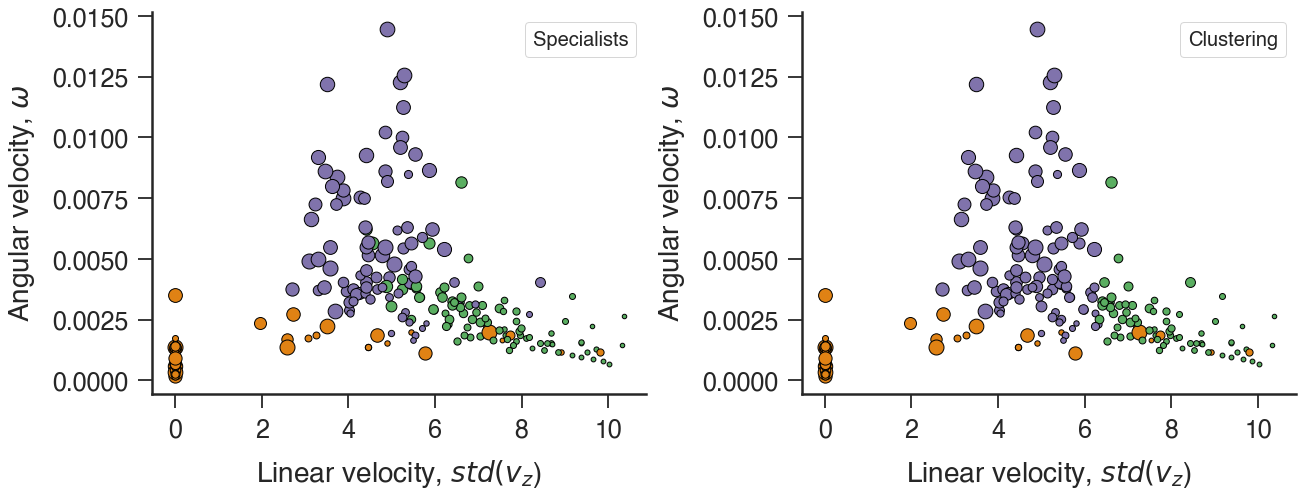

In [15]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nrows=1, ncols=2))

orange_ = "#e08214" #periodic
purple_ = "#8073ac" #chaotic
green_  = "#5aae61" #tumbling
grey_   = "#bababa"

#first panel
for osc, vz, class_, size_ in zip(circle_w, circle_vz, circle_human_class, circle_radii):
    if class_==1:
        ax[0].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[0].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[0].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

#second panel
for osc, vz, class_, size_ in zip(circle_w, circle_vz, circle_feat_class, circle_radii):
    if class_==1:
        ax[1].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[1].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(osc, vz, 'o', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

ax[0].legend(['Specialists'], handlelength=0, handletextpad=0, markerscale=0)
ax[1].legend(['Clustering'], handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Angular velocity, $\omega$')
    ax[i].set_xlabel('Linear velocity, $std(v_z$)')
    
f.tight_layout()

## Disk - Complexity-entropy or Fisher-Shannon plane

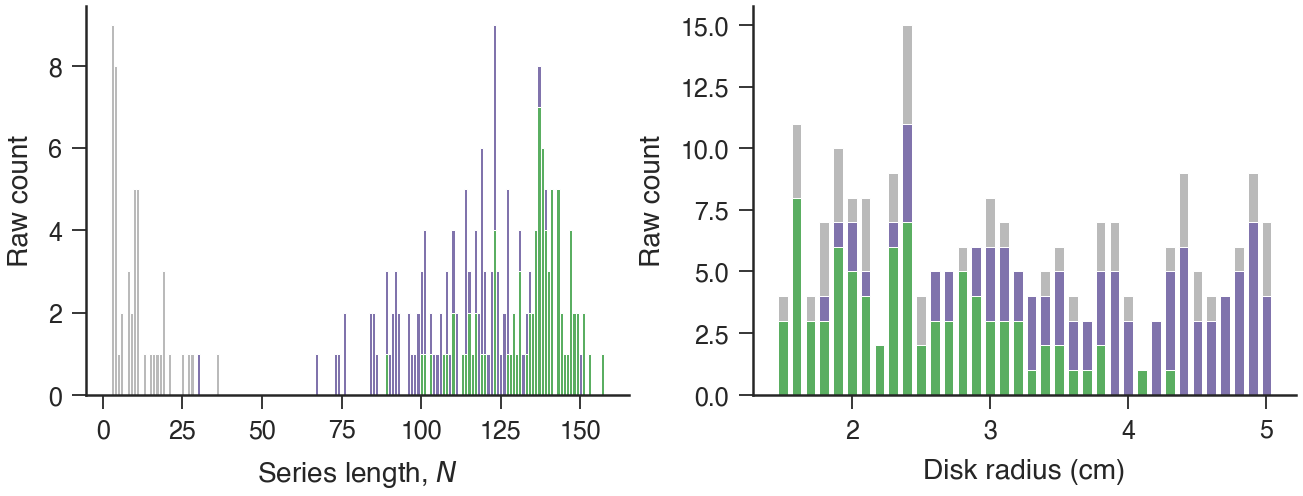

In [492]:
#Series length and falling paper radius histograms

# green  - Tumbling
# purple - Chaotic
# grey   - Steady or periodic behavior

f, ax  = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))
width_ = 1

lengths = np.asarray([len(i) for i in circle_trajectories])
x, y    = np.unique([len(i) for i in circle_trajectories], return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(circle_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=green_)
        elif x_==2:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=purple_)
        else:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=grey_)

        j+=y_
        
ax[0].set_xlabel('Series length')
ax[0].set_ylabel('Raw count')
        
###############################################################################################################
        
lengths = 100*np.asarray([i for i in circle_radii]).round(decimals=3)
x, y    = np.unique(lengths, return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(circle_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[1].bar(length_, y_, bottom=j, color=green_, width=.07, zorder=0)
        elif x_==2:
            ax[1].bar(length_, y_, bottom=j, color=purple_, width=.07, zorder=1)
        else:
#             pass
            ax[1].bar(length_, y_, bottom=j, color=grey_,  width=.07, zorder=2)

        j+=y_

ax[1].set_xlabel('Disk radius (cm)')
ax[1].set_ylabel('Raw count')

f.tight_layout()

In [577]:
# Results for randomized series.

# traj_randomized                 = []

# for dx_ in range(6,7):
#     for i in range(100):
#         circle_ce               = []
#         circle_cluster          = []
#         circle_size             = []
#         circle_human_chaos_tumb = []

        
#         for i, st, ts1, ts2, class_, size_ in zip(range(len(circle_trajectories)), circle_trajectories, 
#                                                   circle_cam1, circle_cam2, circle_human_class, circle_radii):
#         #Complexity-Entropy plane
#             if class_==3:
#                 try:
#                     ts     = np.stack((ts1, ts2), axis=1)
# #                     ts     = st
#                     np.random.shuffle(ts)
#         #             h_, c_ = new_plane(ts, dx_)
#                     p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
#                     h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
#                     circle_ce.append((h_, c_))
#                 except:
#                     circle_ce.append((np.nan, np.nan))
#             else:
#                 ts     = np.stack((ts1, ts2), axis=1)
# #                 ts     = st
#                 np.random.shuffle(ts)

#         #         h_, c_ = new_plane(ts, dx_)
#                 p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
#                 h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
#                 circle_ce.append((h_, c_))
#                 circle_cluster.append((h_, c_))
#                 circle_size.append(size_)
#                 circle_human_chaos_tumb.append(class_)

#         #clustering to generate the second panel data
#         circle_cluster          = np.asarray(circle_cluster).reshape(-1,2) #standardizing permutation features
#         scaler                  = StandardScaler()
#         circle_cluster_features = scaler.fit_transform(circle_cluster)
#         circle_pred             = KMeans(n_clusters=2, random_state=42).fit(circle_cluster_features).labels_ 

#         for (h_, c_), class_, size_ in zip(circle_cluster, circle_pred, circle_size):
#             if class_==0:
#                 ax[1].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
#             else:
#                 ax[1].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_)    


#         ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)
#         axins.legend(['Experts'], loc='lower left', handlelength=0, handletextpad=0, markerscale=0)
#         for i in range(2):
#             ax[i].set_ylabel('Fisher information, $F$')
#             ax[i].set_xlabel('Permutation entropy, $H$')

#         _, b = np.unique(circle_human_class[circle_human_class!=3], return_counts=True)
#         b    = b/b.sum()
# #         print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
# #         print('Tumbling = {}%'.format(b.round(decimals=1)[0]*100))
# #         print('Chaotic  = {}%'.format(b.round(decimals=1)[1]*100), '\n')


#         circle_pred_copy_1 = np.where(circle_pred==0, 2, circle_pred)

#         circle_pred_copy_2 = np.where(circle_pred==1, 2, circle_pred)
#         circle_pred_copy_2 = np.where(circle_pred==0, 1, circle_pred_copy_2)

#         circle_pred_copy_2 = sum(circle_human_chaos_tumb==circle_pred_copy_2)/len(circle_pred_copy_2)
#         circle_pred_copy_1 = sum(circle_human_chaos_tumb==circle_pred_copy_1)/len(circle_pred_copy_1)

#         if circle_pred_copy_2>circle_pred_copy_1:
#             circle_pred_copy=circle_pred_copy_2
#         else:
#             circle_pred_copy=circle_pred_copy_1
            
#         traj_randomized.append(circle_pred_copy)

# #         print('Comparison between our clustering and the clustering based on time series statistics (original approach):', circle_pred_copy)

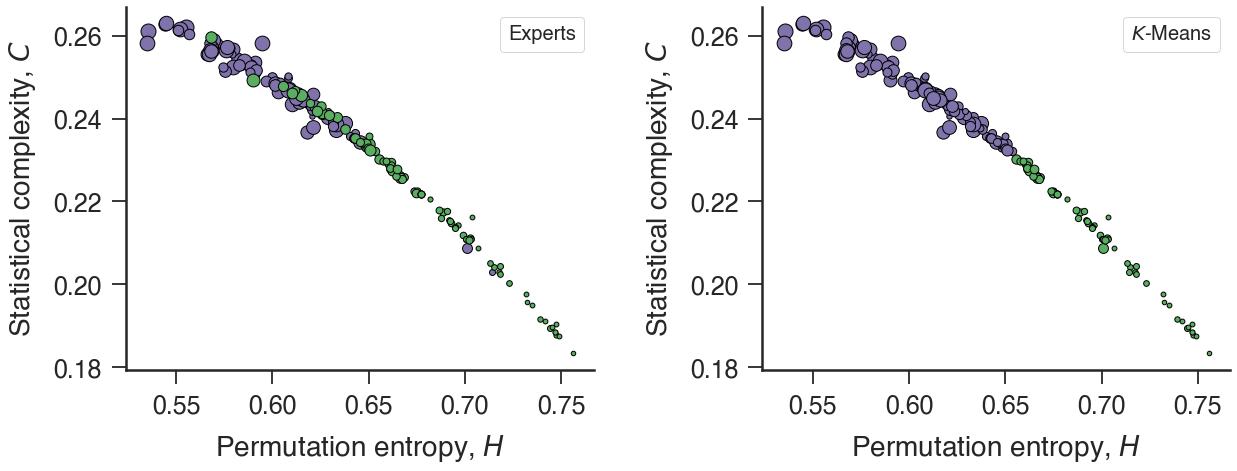

In [85]:
dx_                     = 3
circle_ce               = []
circle_lengths          = []
circle_cluster          = []
circle_size             = []
circle_human_chaos_tumb = []

for i, st, ts1, ts2, class_, size_ in zip(range(len(circle_trajectories)), circle_trajectories, 
                                          circle_cam1, circle_cam2, circle_human_class, circle_radii):

    if class_==3: #steady or periodic time series
        try:
#             ts = st #3d trajectory time series           
            ts     = np.stack((ts1, ts2), axis=1) #observable area time series

#             np.random.shuffle(ts) #randomize time series 

            p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)

#             h_, c_ = new_plane(ts, dx_)          
#             h_, c_ = fisher_shannon(ts, dx=dx_, multi=True)
#             h_, c_ = ordpy.complexity_entropy(ts2, dx=dx_, probs=False)
            circle_ce.append((h_, c_))
        except:
            circle_ce.append((0,0))
            
    else: #tumbling or chaotic time series
#         ts = st #3d trajectory time series           
        ts     = np.stack((ts1, ts2), axis=1) #observable area time series

#         np.random.shuffle(ts) #randomize time series

        p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
#         h_, c_ = new_plane(ts, dx_)

#         h_, c_ = fisher_shannon(ts, dx=dx_, multi=True)
#         h_, c_ = ordpy.complexity_entropy(ts2, dx=dx_, probs=False)
        circle_ce.append((h_, c_))
        circle_lengths.append(len(ts1))
        circle_cluster.append((h_, c_))
        circle_size.append(size_)
        circle_human_chaos_tumb.append(class_)
        
#figure creation
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(scale=.95, nrows=1, ncols=2))
ax    = ax.flatten()

#inset first panel
# axins = inset_axes(ax[0], width="90%", height="100%",
#                    bbox_to_anchor=(.35, .05, .7, .5),
#                    bbox_transform=ax[0].transAxes, loc=3)
# axins.tick_params(length=5, pad=0)

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"

i, j = 0, 0
for (h_, c_), class_, size_ in zip(circle_ce, circle_human_class, circle_radii): #periodic, tumbling and chaotic
    if class_ == 1: #tumbling
        ax[0].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_)
#         ax[0].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=orange_)
#         axins.plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_) #green is tumbling
    elif class_ == 2: #chaotic
        ax[0].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', label='Chaotic', color=purple_, zorder=0)
#         ax[0].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', label='Chaotic', color=orange_, zorder=0)
#         axins.plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0) #purple is chaotic
    if class_ == 3:
        pass
#         try:
#             ax[0].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=grey_)
#         except:
#             pass        
        
#clustering to generate the second panel data
circle_cluster          = np.asarray(circle_cluster).reshape(-1,2) #standardizing permutation features
scaler                  = StandardScaler()
circle_cluster_features = scaler.fit_transform(circle_cluster)
circle_pred             = KMeans(n_clusters=2, random_state=42).fit(circle_cluster_features).labels_ 

for (h_, c_), class_, size_ in zip(circle_cluster, circle_pred, circle_size): #marker size proportional to series length
# for (h_, c_), class_, size_ in zip(circle_cluster, circle_pred, circle_lengths): #marker size proportional to series length
    if class_==1:
        ax[1].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_)
    else:
        ax[1].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)    
    
    
ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)
ax[0].legend(['Experts'], handlelength=0, handletextpad=0, markerscale=0)

for i in range(2):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
# f.savefig('figures/final_figures/circle-ce-dx:{}-dims:{}.svg'.format(dx_, 2), bbox_inches='tight')

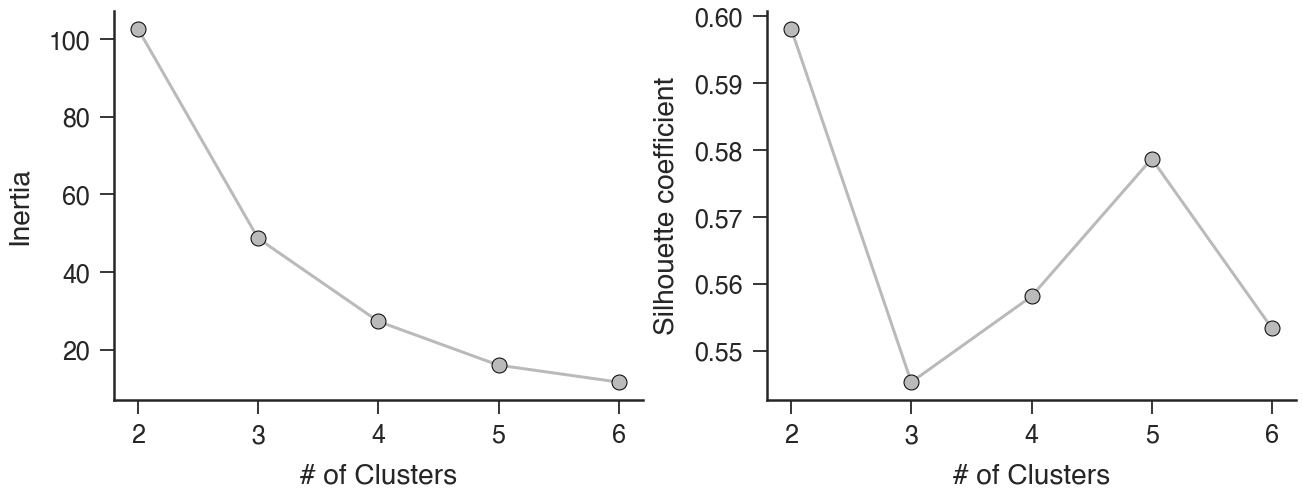

In [115]:
inertia = []
KMEANS  = []
circle_cluster          = np.asarray(circle_cluster).reshape(-1,2) #standardizing permutation features
scaler                  = StandardScaler()
circle_cluster_features = scaler.fit_transform(circle_cluster)

for k in range(2,7):
    inertia.append(KMeans(n_clusters=k, random_state=42).fit(circle_cluster_features).inertia_)
    KMEANS.append(KMeans(n_clusters=k, random_state=42).fit(circle_cluster_features))
    # circle_pred             = KMeans(n_clusters=2, random_state=42).fit(circle_cluster_features).labels_ 
    

silhouette_kmeans = [silhouette_score(circle_cluster_features, kmean_.labels_) for kmean_ in KMEANS]

f, ax = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))

ax[0].plot([2,3,4,5,6], inertia, '-o', markersize=15, markeredgecolor='black', color=grey_)
ax[0].set_xlabel('# of Clusters')
ax[0].set_ylabel('Inertia')

ax[1].plot([2,3,4,5,6], silhouette_kmeans, '-o', markersize=15, markeredgecolor='black', color=grey_)
ax[1].set_xlabel('# of Clusters')
ax[1].set_ylabel('Silhouette coefficient')

f.tight_layout()

In [121]:
#Skew tent map
def skew_tent_map(n=2**15, omega=0.1847, x0=.5):
    """
    Iterates the Skew tent map.
    
    Parameters
    ----------
    n     : time series length.
    omega : map parameter.
    x0    : initial condition.
    ----------
    Returns an array corresponding to a 
    time series.
    """
    x    = np.zeros(n)
    x[0] = x0
    
    for i in range(1, len(x)):
        if x[i-1] < omega:
            x[i] = x[i-1]/omega
        else:
            x[i] = (1-x[i-1])/(1-omega)
    
    return x

#Logistic map
def logistic_map(n=2**15, r=4, x0=0.4):
    """
    Iterates the logistic map.
    
    Parameters
    ----------
    n  : number of map iterations (length of the series).
    x0 : initial population ([0,1] interval)
    r  : intrinsic growth rate (r >= 0; interesting in [0,4] because then, it 
         maps the orbit to the [0,1] interval to itself.)
    ----------
    Returns a logistic map orbit.
    """
    x    = np.zeros(n)
    x[0] = x0
    
    for i in range(n-1):
        x[i+1] = r*x[i]*(1-x[i])
        
    return x

#Henon's map
def henon_map(n=2**15, a=1.4, b=0.3, x0=.5, y0=.5):
    """
    Paramenters
    -----------
    n  : time series length.
    a  : map parameter.
    b  : map parameter.
    x0 : initial condition.
    y0 : initial condition.
    -----------
    
    Returns the x and y variables of Henón's map.
    """
    with warnings.catch_warnings():
        warnings.simplefilter("error")
            
        bool_ = False
        while bool_==False:        
            try:
                x    = np.zeros(n)
                y    = np.zeros(n)

                x[0] = x0
                y[0] = y0

                for i in range(1, n):
                    x[i] = 1 - a*x[i-1]**2 + y[i-1]
                    y[i] = b*x[i-1]

                bool_ = True

            except RuntimeWarning: #changes the random inital condition
                x0 = np.random.uniform()
                y0 = np.random.uniform()

    return x, y

#Schuster's map
def schuster_map(n=2**15, z=2, x0=.5):
    """
    
    Parameters
    ----------
    n : time series length
    z :  map parameter
    ----------
    Returns an orbit of an iterated Schuster map.
    """
    z    = float(z)
    x    = np.zeros(n)
    x[0] = x0
    
    for i in range(1, n):
        x[i], _ = np.modf(x[i-1] + x[i-1]**z)
    
    return x

In [143]:
import warnings
import colorednoise
import chvr

In [138]:
hc_stentmap            = np.mean([ordpy.complexity_entropy(skew_tent_map(x0=np.random.uniform()), dx=3) for _ in range(10)], axis=0)
hc_henon_x, hc_henon_y = np.mean([[ordpy.complexity_entropy(x_, dx=3), ordpy.complexity_entropy(y_, dx=3)] for x_, y_ in [(henon_map(x0=np.random.uniform(), y0=np.random.uniform())) for _ in range(10)]], axis=0)
hc_logistic            = np.mean([ordpy.complexity_entropy(logistic_map(x0=np.random.uniform()), dx=3) for _ in range(10)], axis=0)
hc_schuster            = np.mean([[ordpy.complexity_entropy(schuster_map(z=z_, x0=np.random.uniform()), dx=3) for _ in range(10)] for z_ in [3/2, 2, 5/2]], axis=1)
hc_knoise              = np.mean([[ordpy.complexity_entropy(colorednoise.powerlaw_psd_gaussian(exponent=k_, size=2**15), dx=3)for _ in range(10)] for k_ in np.arange(0, 3.1, .25).round(decimals=2)], axis=1)

# #theoretical curves
hc_max_curve = ordpy.maximum_complexity_entropy(dx=3).T
hc_min_curve = ordpy.minimum_complexity_entropy(dx=3, size=719).T

# 12 minutes to Run. Fbm and fGn in Fig 1a
# hc_fbm = np.mean([[ordpy.complexity_entropy(chvr.fbm(n=15, h=h_, acum=1), dx=3) for _ in range(10)] for h_ in np.arange(.1,.91,.1).round(decimals=2)], axis=1)
# hc_fgn = np.mean([[ordpy.complexity_entropy(chvr.fbm(n=15, h=h_, acum=0), dx=3) for _ in range(10)] for h_ in np.arange(.1,.91,.1).round(decimals=2)], axis=1)

# np.save('figures/hc_fgn.npy', hc_fgn)
# np.save('figures/hc_fbm.npy', hc_fbm)

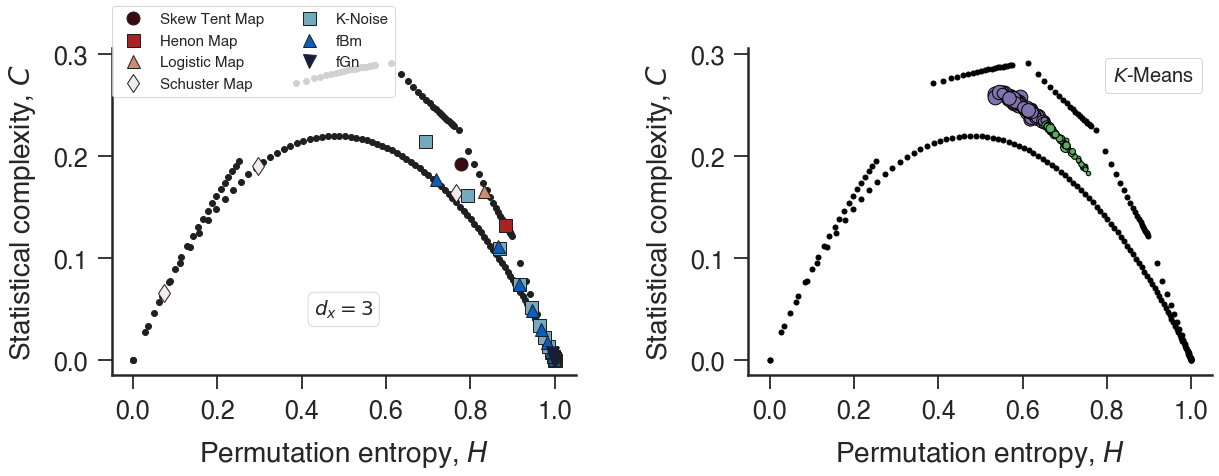

In [163]:
#figure creation
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(scale=.95, nrows=1, ncols=2))
ax    = ax.flatten()

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"
##################################################################

hc_data = [hc_stentmap, hc_henon_x, hc_logistic, hc_schuster, hc_knoise, hc_fbm, hc_fgn]
labels  = ['Skew Tent Map', 'Henon Map', 'Logistic Map', 'Schuster Map', 'K-Noise','fBm', 'fGn']
markers = ['o', 's', '^', 'd', 's', '^', 'v']

#palettable.cmocean.diverging.Balance_7_r.hex_colors
colors = ['#3C0912', '#A72424', '#D08B73', '#F1ECEB', '#75AABE', '#0C5EBE', '#181C43'] 


for data_, marker_, color_, label_, cnt in zip(hc_data, markers, colors,
                                               labels, range(len(hc_data))):
    #point plotting
    h_, c_ = data_.T
    ax[0].plot(h_, c_, marker_, markersize=13, markeredgecolor='#202020', color=color_, label=label_)

    #dotted #202020 line connecting dots
#     if cnt > 2:
#         ax[0].plot(h_, c_, '--', linewidth=1, color='#202020', zorder=0)

#         #annotations
#         if cnt == 3:  #schuster map
#             for tx_, x_, y_ in zip(['3/2', '2', '5/2'], h_ + np.asarray([.025] * 3), c_ + np.asarray([-.002] * 3)):
#                 ax[0].annotate('$z = {}$'.format(tx_), xy=(x_, y_), fontsize=15, color='black')
#         if cnt == 4:  #colored noise
#             adjx_ = [0.015, 0.025, -.005, 0.0]
#             adjy_ = [-0.00, -0.005, 0.015, .015]
#             ncnt = 0
#             for n_, x_, y_ in zip(np.arange(0, 3.1, .25).round(decimals=2), h_, c_):
#                 if n_ in [0, 1, 2, 3]:
#                     ax[0].annotate('$k = {}$'.format(int(n_)),
#                                    xy=(x_ + adjx_[ncnt], y_ + adjy_[ncnt]),
#                                    fontsize=15,
#                                    color='#202020')
#                     ncnt += 1
#         if cnt == 5:  #fBm
#             for tx_, x_, y_, adjx_, adjy_ in zip(['0.1', '0.5', '0.9'],
#                                                  h_[[0, 4, 8]], c_[[0, 4, 8]],
#                                                  [-.14, -.13, -.04],
#                                                  [-0.008, -0.010, -0.03]):
#                 ax[0].annotate(r'$h = {}$'.format(tx_),
#                                xy=(x_ + adjx_, y_ + adjy_),
#                                fontsize=15,
#                                color='#202020')

# ax[0].set_ylim(bottom=0, top=.51)
# ax[0].set_xlim(left=0, right=1.06)

#theoretical curves

# ax[1].plot(*ordpy.minimum_complexity_entropy(dx=3, size=100).T,  '.', marker='.', markersize=10, markeredgecolor='black', color='black', zorder=0)    
# ax[1].plot(*ordpy.maximum_complexity_entropy(dx=3, m=20).T,  '.', marker='.', markersize=10, markeredgecolor='black', color='black', zorder=0)    

hmin, cmin = ordpy.minimum_complexity_entropy(dx=3, size=100).T  #(this variable is defined in the cell above)
hmax, cmax = ordpy.maximum_complexity_entropy(dx=3, m=20).T  #(this variable is defined in the cell above)
ax[0].plot(hmin, cmin, '.', marker='o', color='#202020', zorder=0)
ax[0].plot(hmax, cmax, '.', marker='o', color='#202020', zorder=0)

ax[0].set_ylabel('Statistical complexity, $C$')
ax[0].set_xlabel('Permutation entropy, $H$')
ax[0].annotate('$d_x = 3$', (.5, .2),
               va='center',
               ha='center',
               xycoords='axes fraction',
               fontsize=20,
               bbox={
                   'boxstyle': 'round',
                   'fc': 'white',
                   'alpha': 1,
                   'ec': '#d9d9d9'
               })
ax[0].legend(frameon=True, loc=(0, .85), ncol=2, fontsize=15)

#################################################################
#clustering to generate the second panel data
circle_cluster          = np.asarray(circle_cluster).reshape(-1,2) #standardizing permutation features
scaler                  = StandardScaler()
circle_cluster_features = scaler.fit_transform(circle_cluster)
circle_pred             = KMeans(n_clusters=2, random_state=42).fit(circle_cluster_features).labels_ 

for (h_, c_), class_, size_ in zip(circle_cluster, circle_pred, circle_size): #marker size proportional to series length
# for (h_, c_), class_, size_ in zip(circle_cluster, circle_pred, circle_lengths): #marker size proportional to series length
    if class_==1:
        ax[1].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_)
    else:
        ax[1].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)    
    
ax[1].plot(*ordpy.minimum_complexity_entropy(dx=3, size=100).T,  '.', marker='.', markersize=10, markeredgecolor='black', color='black', zorder=0)    
ax[1].plot(*ordpy.maximum_complexity_entropy(dx=3, m=20).T,  '.', marker='.', markersize=10, markeredgecolor='black', color='black', zorder=0)    
    
ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)

for i in range(2):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
# f.savefig('figures/final_figures/circle-ce-dx:{}-dims:{}.svg'.format(dx_, 2), bbox_inches='tight')

In [53]:
print('Number of time series of falling (circular) papers: ', len(circle_human_class))

Number of time series of falling (circular) papers:  218


In [511]:
_, b = np.unique(circle_human_class, return_counts=True)
b    = 100*b/b.sum()

print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
print('Tumbling         = {}%'.format(b.round(decimals=0)[0]))
print('Chaotic          = {}%'.format(b.round(decimals=0)[1]))
print('Steady/periodic  = {}%'.format(b.round(decimals=0)[2]), '\n')

_, b = np.unique(circle_human_class[circle_human_class!=3], return_counts=True)
b    = 100*b/b.sum()
print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
print('Tumbling = {}%'.format(b.round(decimals=0)[0]))
print('Chaotic  = {}%'.format(b.round(decimals=0)[1]), '\n')

print('Comparison between our "permutation clustering" and the original clustering based on time series statistics:')
circle_pred_copy = np.where(circle_pred==0, 2, circle_pred)

# circle_pred_copy = np.where(circle_pred==1, 2, circle_pred)
# circle_pred_copy = np.where(circle_pred==0, 1, circle_pred_copy)
print('Accuracy using permutation entropy (statistics) strategy: ', sum(circle_human_chaos_tumb==circle_pred_copy)/len(circle_pred_copy))
print('Accuracy of the original paper                          : ', sum(circle_feat_class[circle_feat_class!=3]==circle_human_class[circle_human_class!=3])/len(circle_feat_class[circle_feat_class!=3]))

Relative abundance of tumbling and chaotic trajectories (as categorized by experts):
Tumbling         = 39.0%
Chaotic          = 39.0%
Steady/periodic  = 22.0% 

Relative abundance of tumbling and chaotic trajectories (as categorized by experts):
Tumbling = 49.0%
Chaotic  = 51.0% 

Comparison between our "permutation clustering" and the original clustering based on time series statistics:
Accuracy using permutation entropy (statistics) strategy:  0.8294117647058824
Accuracy of the original paper                          :  0.8529411764705882


In [502]:
#CIRCLE

# FISHER-SHANNON
# Various "embedding dimensions" (two cameras).
print("TWO CAMERAS")
print("dx = 3, ~.888. dx = 4, ~.829. dx = 5, ~.794. dx = 6, ~.765.\n")

# Various "embedding dimensions" (3d trajectory).
print("3D TRAJECTORY")
print("dx = 3, ~.553. dx = 4, ~.553. dx = 5, ~.553. dx = 6, ~.553.")

TWO CAMERAS
dx = 3, ~.888. dx = 4, ~.829. dx = 5, ~.794. dx = 6, ~.765.

3D TRAJECTORY
dx = 3, ~.553. dx = 4, ~.553. dx = 5, ~.553. dx = 6, ~.553.


In [501]:
#CIRCLE
#PJSD-SHANNON

# Various "embedding dimensions" (two cameras).
print("TWO CAMERAS")
print("dx = 3, ~.835. dx = 4, ~.835. dx = 5, ~.865. dx=6, ~.894.\n")

# Various "embedding dimensions" (3d trajectory).
print("3D TRAJECTORY")
print("dx = 3, ~.682. dx = 4, ~.676. dx = 5, ~.694. dx = 6, ~.729.")

TWO CAMERAS
dx = 3, ~.835. dx = 4, ~.835. dx = 5, ~.865. dx=6, ~.894.

3D TRAJECTORY
dx = 3, ~.682. dx = 4, ~.676. dx = 5, ~.694. dx = 6, ~.729.


In [504]:
#CIRCLE
# Various "embedding dimensions" (two cameras).
print("TWO CAMERAS")
print("dx = 3, ~.829. dx = 4, ~.894. dx = 5, ~.876. dx = 6, ~.865.\n")

# Various "embedding dimensions" (camera 1).
print("CAMERA 1")
print("dx = 3, ~.841. dx = 4, ~.841. dx = 5, ~.871. dx = 6, ~.865.\n")

# Various "embedding dimensions" (camera 2).
print("CAMERA 2")
print("dx = 3, ~.800. dx = 4, ~.859. dx = 5, ~.829. dx = 6, ~.865.")

TWO CAMERAS
dx = 3, ~.829. dx = 4, ~.894. dx = 5, ~.876. dx = 6, ~.865.

CAMERA 1
dx = 3, ~.841. dx = 4, ~.841. dx = 5, ~.871. dx = 6, ~.865.

CAMERA 2
dx = 3, ~.800. dx = 4, ~.859. dx = 5, ~.829. dx = 6, ~.865.


In [505]:
#CIRCLE

#Complexity-entropy
# Various embedding dimensions (3D trajectory)
print("3D TRAJECTORY")
print("dx = 3, ~.671. dx = 4, ~.694. dx = 5, ~.782. dx = 6, ~.824. dx=7, ~.847")

3D TRAJECTORY
dx = 3, ~.671. dx = 4, ~.694. dx = 5, ~.782. dx = 6, ~.824. dx=7, ~.847


In [506]:
#CIRCLE (Randomized series - means over 100 realizations)

# Various "embedding dimensions" (two cameras).
print("TWO CAMERAS")
print("dx = 3, ~.539(.027). dx = 4, ~.574(.041). dx = 5, ~.656(.023). dx = 6, ~.702(.014). dx = 7, ~.684(.011).\n")

# Various "embedding dimensions" (time series).
print("3D TRAJECTORY")
print("dx = 3, ~.532(.021). dx = 4, ~.551(.026). dx = 5, ~.597(.015). dx = 6, ~.576(.009). dx = 7, ~.614(.007)")

TWO CAMERAS
dx = 3, ~.539(.027). dx = 4, ~.574(.041). dx = 5, ~.656(.023). dx = 6, ~.702(.014). dx = 7, ~.684(.011).

3D TIME SERIES
dx = 3, ~.532(.021). dx = 4, ~.551(.026). dx = 5, ~.597(.015). dx = 6, ~.576(.009). dx = 7, ~.614(.007)


## 3D - Disk

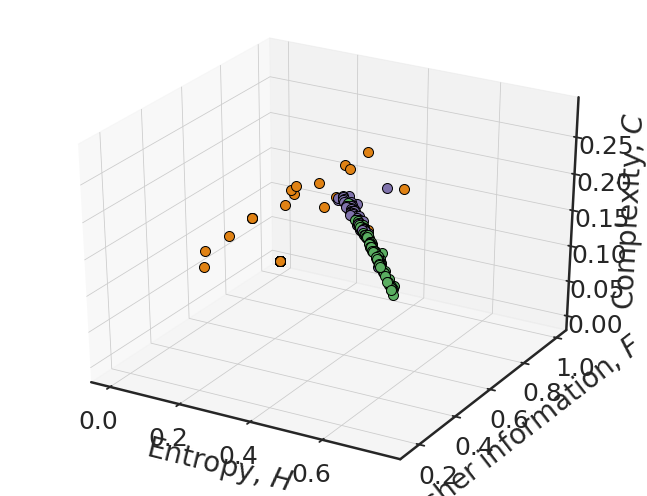

In [227]:
dx_ = 3

pe3d                  = []
pe3d_space            = []
pe3d_human_chaos_tumb = []

for i, ts1, ts2, class_, size_ in zip(range(len(circle_trajectories)), circle_cam1, 
                                      circle_cam2, circle_human_class, circle_radii):
    if class_==3: #steady or periodic
        try:
            ts     = np.stack((normalize(ts1), normalize(ts2)), axis=1)
            p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
            _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
            pe3d.append((h_, f_, c_))
        except:
            pe3d.append((np.nan, np.nan))
            
    else: #chaotic or tumbling
        ts     = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
        _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
        pe3d.append((h_, f_, c_))
        pe3d_space.append((h_, f_, c_))
        pe3d_human_chaos_tumb.append(class_)

###################################################################        
f  = plt.figure()
ax = f.add_subplot(111, projection='3d')

orange_ = "#e08214" #3
purple_ = "#8073ac" #2
green_  = "#5aae61" #1
#(h_, f_, c_)
# for (x_, y_, z_), class_ in zip(pe3d, circle_feat_class): 
for (x_, y_, z_), class_ in zip(pe3d, circle_human_class):
    if class_ == 1: #tumbling
        ax.scatter(x_, y_, z_, marker='o', s=100, color=green_, edgecolor='black')
#         ax.plot(h_, c_, '.', marker='o', markersize=8, markeredgecolor='black', color=green_, zorder=0)
    elif class_ == 2: #chaotic
        ax.scatter(x_, y_, z_, marker='o', s=100, color=purple_, edgecolor='black')        
    if class_ == 3:
        try:
            ax.scatter(x_, y_, z_, marker='o', s=100, color=orange_, edgecolor='black', zorder=0)
        except:
            pass

ax.set_xlabel('Entropy, $H$')
ax.set_ylabel('Fisher information, $F$')
ax.set_zlabel('Complexity, $C$')



#calculation to generate second panel data
pe3d_space = np.asarray(pe3d_space).reshape(-1,3)
pe3d_pred  = KMeans(n_clusters=2, random_state=42).fit(pe3d_space).labels_ 


f.tight_layout()

In [228]:
pe3d_pred_copy_plus_1 = pe3d_pred.copy()+1

sum(pe3d_human_chaos_tumb==pe3d_pred_copy_plus_1)/len(pe3d_pred_copy_plus_1)

0.8823529411764706

In [229]:
pe3d_pred_copy = np.where(pe3d_pred==0, 2, pe3d_pred)

sum(pe3d_human_chaos_tumb==pe3d_pred_copy)/len(pe3d_pred_copy)

0.11764705882352941

In [230]:
# Agreement between the human and the permutation entropy classification
circle_pred = np.where(circle_pred==0, 2, circle_pred)

sum(circle_pred==circle_human_chaos_tumb)/len(circle_pred)

0.8352941176470589

In [231]:
# # Agreement between the human and the permutation entropy classification
# square_pred_copy = square_pred.copy()+1

# sum(square_pred_copy==square_human_chaos_tumb)/len(square_pred_copy)

# Agreement between the human and the permutation entropy classification
pe3d_pred_copy_plus_1 = pe3d_pred.copy()+1

print('Score permutation entropy strategy: ', sum(pe3d_human_chaos_tumb==pe3d_pred_copy_plus_1)/len(pe3d_pred_copy_plus_1), '\n')

print('Score of the original paper strategy: ', sum(square_feat_class[square_feat_class!=3]==square_human_class[square_human_class!=3])/len(square_feat_class[square_feat_class!=3]))

Score permutation entropy strategy:  0.8823529411764706 

Score of the original paper strategy:  0.8478260869565217


# Hexagon

In [17]:
shape_ = "Hexagon"

hex_trajectories, hex_cam1, hex_cam2, hex_radii, hex_conditions, _ = trajectory_cleaning(shape_)
hex_trajectories = np.delete(hex_trajectories, [38, 143, 144])
hex_cam1         = np.delete(hex_cam1, [38, 143, 144])
hex_cam2         = np.delete(hex_cam2, [38, 143, 144])
hex_radii        = np.delete(hex_radii, [38, 143, 144])
hex_conditions   = np.delete(hex_conditions, [38, 143, 144])

# hex_trajectories = np.delete(hex_trajectories, [142])
# hex_cam1         = np.delete(hex_cam1, 142)
# hex_cam2         = np.delete(hex_cam2, 142)
# hex_radii        = np.delete(hex_radii, 142)
# hex_conditions   = np.delete(hex_conditions, 142)

# hex_trajectories = np.delete(hex_trajectories, [39, 143, 142])
# hex_cam1         = np.delete(hex_cam1, [39, 143, 142])
# hex_cam2         = np.delete(hex_cam2, [39, 143, 142])
# hex_radii        = np.delete(hex_radii, [39, 143, 142])
# hex_conditions   = np.delete(hex_conditions, [39, 143, 142])

hex_dx, hex_dy, hex_dz, hex_pathlen, hex_time, hex_w, hex_vz       = original_features(hex_trajectories, hex_cam1, hex_cam2)

/home/arthur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [18]:
saved_dx         = np.delete(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dx'].flatten(), 142)
saved_dy         = np.delete(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dy'].flatten(), 142)
saved_dz         = np.delete(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['dz'].flatten(), 142)
saved_pathlength = np.delete(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['pathLength'].flatten(), 142)
saved_time       = np.delete(scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['time'].flatten(), 142)

In [19]:
test_hex_trajectories, test_hex_cam1, test_hex_cam2, test_hex_radii, test_hex_conditions, _ = trajectory_cleaning(shape_)

In [20]:
hex_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format(shape_))['behaviourHuman'][0]
hex_human_class = np.delete(hex_human_class, [142])

hex_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format(shape_))['behaviourAuto'].flatten()
hex_feat_class  = np.delete(hex_feat_class, [142])

In [21]:
# #Cheking if the "cleaned" series correspond to the correct ones (the ones published in the original paper).

# for a, b, c, d, e, f, g,  k in zip(saved_dx==np.asarray(hex_dx), 
#                                    saved_dy==np.asarray(hex_dy), 
#                                    saved_dz==np.asarray(hex_dz), 
#                                    saved_pathlength, hex_pathlen,
#                                    saved_time, hex_time,
#                                    range(len(hex_dx))):

#     print(a, b, c, abs(d-e)<0.0001, abs(f-g)<0.0001, k)

## Hexagon - Original features plane (angular velocity vs linear velocity)

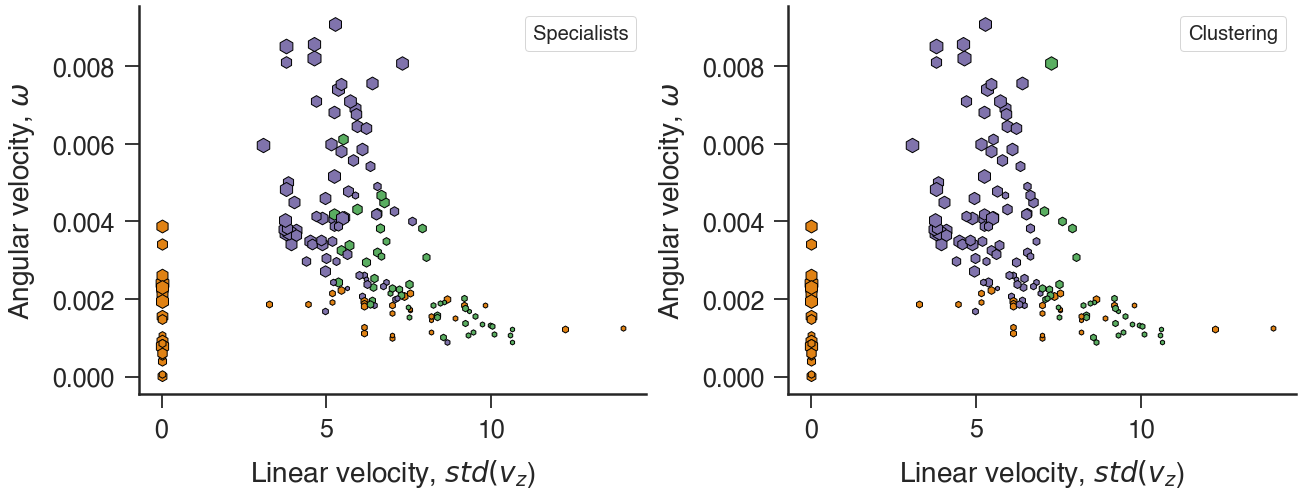

In [22]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nrows=1, ncols=2))

orange_ = "#e08214"
purple_ = "#8073ac" #chaotic
green_  = "#5aae61" #tumbling

#first panel
for osc, vz, class_, size_ in zip(hex_w, hex_vz, hex_human_class, hex_radii):
    if class_==1:
        ax[0].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[0].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[0].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

#second panel
for osc, vz, class_, size_ in zip(hex_w, hex_vz, hex_feat_class, hex_radii):
    if class_==1:
        ax[1].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[1].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(osc, vz, 'h', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

ax[0].legend(['Specialists'], handlelength=0, handletextpad=0, markerscale=0)
ax[1].legend(['Clustering'], handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Angular velocity, $\omega$')
    ax[i].set_xlabel('Linear velocity, $std(v_z$)')
    
f.tight_layout()

## Hexagon - Complexity-entropy or Fisher-Shannon plane

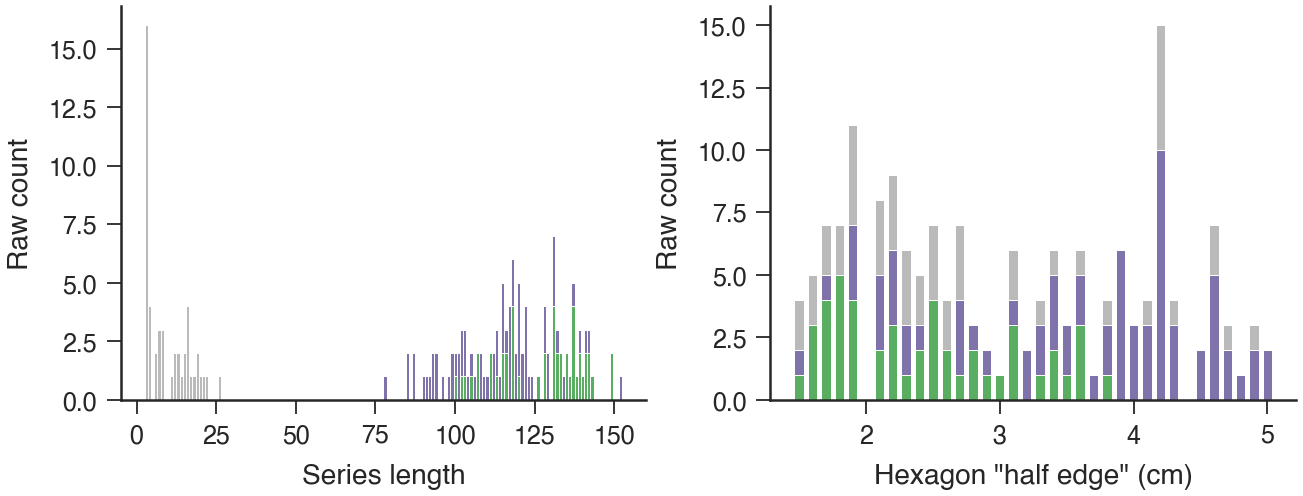

In [23]:
#Series length and falling paper radius histograms

# green  - Tumbling
# purple - Chaotic
# grey   - Steady or periodic behavior

f, ax  = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))
width_ = 1

lengths = np.asarray([len(i) for i in hex_trajectories])
x, y    = np.unique([len(i) for i in hex_trajectories], return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(hex_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=green_)
        elif x_==2:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=purple_)
        else:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=grey_)

        j+=y_
        
ax[0].set_xlabel('Series length')
ax[0].set_ylabel('Raw count')
        
###############################################################################################################
        
lengths = 100*np.asarray([i for i in hex_radii]).round(decimals=3)
x, y    = np.unique(lengths, return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(hex_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[1].bar(length_, y_, bottom=j, color=green_, width=.07, zorder=0)
        elif x_==2:
            ax[1].bar(length_, y_, bottom=j, color=purple_, width=.07, zorder=1)
        else:
#             pass
            ax[1].bar(length_, y_, bottom=j, color=grey_,  width=.07, zorder=2)

        j+=y_

ax[1].set_xlabel('Hexagon \"half edge\" (cm)')
ax[1].set_ylabel('Raw count')

f.tight_layout()

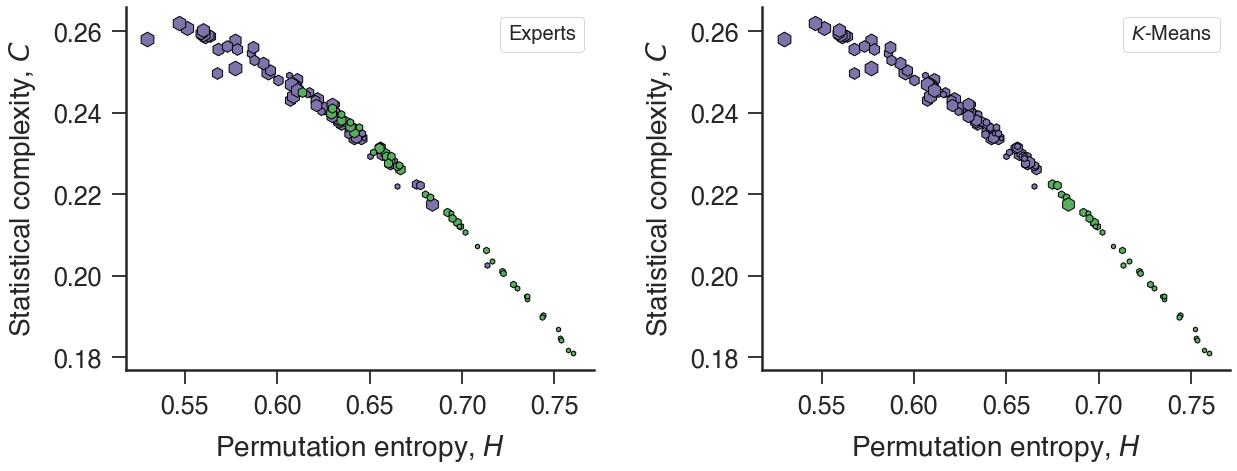

In [99]:
dx_                  = 3
hex_ce               = []
hex_lengths          = []
hex_cluster          = []
hex_size             = []
hex_human_chaos_tumb = []

for i, st, ts1, ts2, class_, size_ in zip(range(len(hex_trajectories)), hex_trajectories, 
                                          hex_cam1, hex_cam2, hex_human_class, hex_radii):

    if class_==3: #steady or periodic time series
        try:
#             ts = st #3d trajectory time series           
            ts     = np.stack((ts1, ts2), axis=1) #observable area time series

#             np.random.shuffle(ts) #randomize time series 

            p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)

#             h_, c_ = new_plane(ts, dx_)          
#             h_, c_ = fisher_shannon(ts, dx=dx_, multi=True)
#             h_, c_ = ordpy.complexity_entropy(ts2, dx=dx_, probs=False)
            hex_ce.append((h_, c_))
        except:
            hex_ce.append((0,0))
            
    else: #tumbling or chaotic time series
#         ts = st #3d trajectory time series           
        ts     = np.stack((ts1, ts2), axis=1) #observable area time series

#         np.random.shuffle(ts) #randomize time series

        p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
#         h_, c_ = new_plane(ts, dx_)

#         h_, c_ = fisher_shannon(ts, dx=dx_, multi=True)
#         h_, c_ = ordpy.complexity_entropy(ts2, dx=dx_, probs=False)
        hex_ce.append((h_, c_))
        hex_lengths.append(len(ts1))
        hex_cluster.append((h_, c_))
        hex_size.append(size_)
        hex_human_chaos_tumb.append(class_)
        
#figure creation
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(scale=.95, nrows=1, ncols=2))
ax    = ax.flatten()

#inset first panel
# axins = inset_axes(ax[0], width="90%", height="100%",
#                    bbox_to_anchor=(.35, .05, .7, .5),
#                    bbox_transform=ax[0].transAxes, loc=3)
# axins.tick_params(length=5, pad=0)

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"

i, j = 0, 0
for (h_, c_), class_, size_ in zip(hex_ce, hex_human_class, hex_radii): #periodic, tumbling and chaotic
    if class_ == 1: #tumbling
        ax[0].plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=green_)
#         ax[0].plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=orange_)
#         axins.plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=green_) #green is tumbling
    elif class_ == 2: #chaotic
        ax[0].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', label='Chaotic', color=purple_, zorder=0)
#         ax[0].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', label='Chaotic', color=orange_, zorder=0)
#         axins.plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0) #purple is chaotic
    if class_ == 3:
        pass
#         try:
#             ax[0].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=grey_)
#         except:
#             pass        
        
#clustering to generate the second panel data
hex_cluster          = np.asarray(hex_cluster).reshape(-1,2) #standardizing permutation features
scaler               = StandardScaler()
hex_cluster_features = scaler.fit_transform(hex_cluster)
hex_pred             = KMeans(n_clusters=2, random_state=42).fit(hex_cluster_features).labels_ 

for (h_, c_), class_, size_ in zip(hex_cluster, hex_pred, hex_size): #marker size proportional to series length
# for (h_, c_), class_, size_ in zip(hex_cluster, hex_pred, hex_lengths): #marker size proportional to series length
    if class_==1:
        ax[1].plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=green_)
    else:
        ax[1].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)    
    
    
ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)
ax[0].legend(['Experts'], handlelength=0, handletextpad=0, markerscale=0)

for i in range(2):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
# f.savefig('figures/final_figures/hexagon-ce-dx:{}-dims:{}.svg'.format(dx_, 2), bbox_inches='tight')

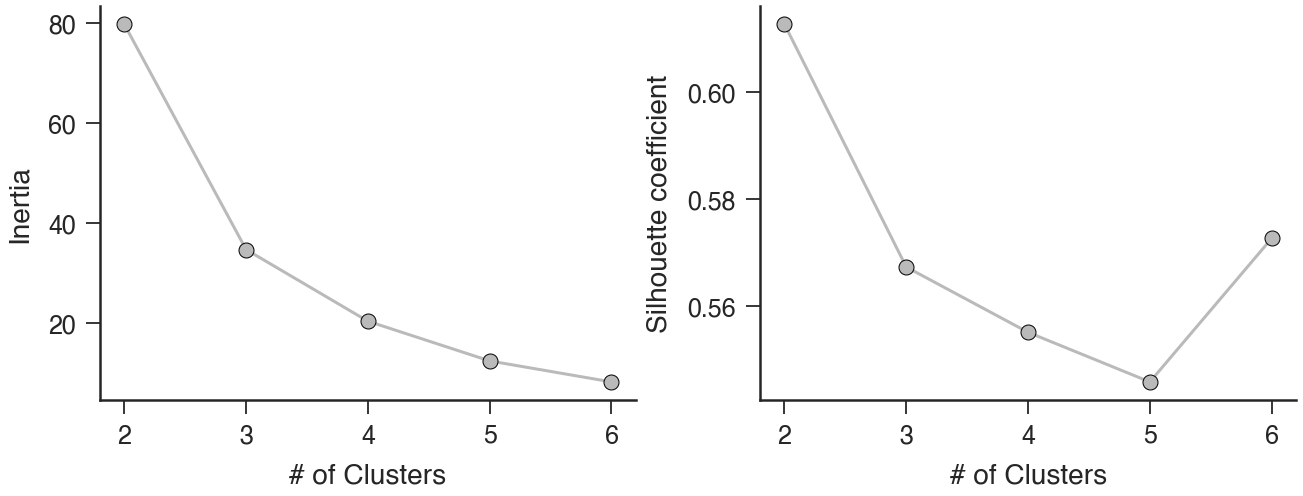

In [114]:
inertia = []
KMEANS  = []
hex_cluster          = np.asarray(hex_cluster).reshape(-1,2) #standardizing permutation features
scaler               = StandardScaler()
hex_cluster_features = scaler.fit_transform(hex_cluster)

for k in range(2,7):
    inertia.append(KMeans(n_clusters=k, random_state=42).fit(hex_cluster_features).inertia_)
    KMEANS.append(KMeans(n_clusters=k, random_state=42).fit(hex_cluster_features))
    # hex_pred             = KMeans(n_clusters=2, random_state=42).fit(hex_cluster_features).labels_ 
    

silhouette_kmeans = [silhouette_score(hex_cluster_features, kmean_.labels_) for kmean_ in KMEANS]

f, ax = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))

ax[0].plot([2,3,4,5,6], inertia, '-o', markersize=15, markeredgecolor='black', color=grey_)
ax[0].set_xlabel('# of Clusters')
ax[0].set_ylabel('Inertia')

ax[1].plot([2,3,4,5,6], silhouette_kmeans, '-o', markersize=15, markeredgecolor='black', color=grey_)
ax[1].set_xlabel('# of Clusters')
ax[1].set_ylabel('Silhouette coefficient')

f.tight_layout()

In [112]:
#Antes de averiguar o resultado, tem de ver a posição dos '3' nas classificações humana e automática. Não é tão trivial assim.
# np.where(hex_human_class==3)[0].flatten()==np.where(hex_feat_class==3)[0].flatten()

In [55]:
print('Number of time series of falling (hexagonal) papers: ', len(hex_human_class))

Number of time series of falling (hexagonal) papers:  168


In [524]:
_, b = np.unique(hex_human_class, return_counts=True)
b    = 100*b/b.sum()

print('Relative abundance of tumbling, chaotic and steady(periodic) trajectories (as categorized by experts):')
print('Tumbling         = {}%'.format(b.round(decimals=0)[0]))
print('Chaotic          = {}%'.format(b.round(decimals=0)[1]))
print('Steady/periodic  = {}%'.format(b.round(decimals=0)[2]), '\n')

_, b = np.unique(hex_human_class[hex_human_class!=3], return_counts=True)
b    = 100*b/b.sum()
print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
print('Tumbling = {}%'.format(b.round(decimals=0)[0]))
print('Chaotic  = {}%'.format(b.round(decimals=0)[1]), '\n')


print('Comparison between our clustering and the clustering based on time series statistics (original approach):')
hex_pred_copy = np.where(hex_pred==0, 2, hex_pred)

# hex_pred_copy = np.where(hex_pred==1, 2, hex_pred)
# hex_pred_copy = np.where(hex_pred==0, 1, hex_pred_copy)
print('Accuracy using permutation entropy (statistics) strategy: ', sum(hex_human_chaos_tumb==hex_pred_copy)/len(hex_pred_copy))
print('Accuracy of the original paper                          : ', sum(hex_feat_class[hex_feat_class!=3]==hex_human_class[hex_human_class!=3])/len(hex_feat_class[hex_feat_class!=3]))

Relative abundance of tumbling, chaotic and steady(periodic) trajectories (as categorized by experts):
Tumbling         = 28.0%
Chaotic          = 43.0%
Steady/periodic  = 29.0% 

Relative abundance of tumbling and chaotic trajectories (as categorized by experts):
Tumbling = 39.0%
Chaotic  = 61.0% 

Comparison between our clustering and the clustering based on time series statistics (original approach):
Accuracy using permutation entropy (statistics) strategy:  0.8
Accuracy of the original paper                          :  0.7916666666666666


In [532]:
#HEXAGON
# FISHER-SHANNON
# two cameras, several embedding dimensions 
print("TWO CAMERAS")
print("dx=3, ~.8000; dx=4, ~.7750; dx=5, ~.800; dx=6, ~.8083.\n")

# FISHER-SHANNON
# 3d trajectory, several embedding dimensions 
print("3D TRAJECTORY")
print("dx=3, ~.7750; dx=4, ~.8083; dx=5, ~.8167; dx=6, ~.8083.")

TWO CAMERAS
dx=3, ~.8000; dx=4, ~.7750; dx=5, ~.800; dx=6, ~.8083.

3D TRAJECTORY
dx=3, ~.7750; dx=4, ~.8083; dx=5, ~.8167; dx=6, ~.8083


In [531]:
#HEXAGON
# two cameras, several embedding dimensions 
print("TWO CAMERAS")
print("dx=3, ~.8000; dx=4, ~.7416; dx=5, ~.7916; dx=6, ~.7333.\n")

# "camera 1", several embedding dimensions 
print("CAMERA 1")
print("dx=3, ~.8417; dx=4, ~.8250; dx=5, ~.8417; dx=6, ~.7750.\n")

# "camera 2", several embedding dimensions 
print("CAMERA 2")
print("dx=3, ~.7417; dx=4, ~.7333; dx=5, ~.7167; dx=6, ~.7167.")

TWO CAMERAS
dx=3, ~.8000; dx=4, ~.7416; dx=5, ~.7916; dx=6, ~.7333.

CAMERA 1
dx=3, ~.8417; dx=4, ~.8250; dx=5, ~.8417; dx=6, ~.7750.

CAMERA 2
dx=3, ~.7417; dx=4, ~.7333; dx=5, ~.7167; dx=6, ~.7167.


In [527]:
#HEXAGON
#PJSD-SHANNON
# Various "embedding dimensions" (two cameras).
print("TWO CAMERAS")
print("dx = 3, ~.800. dx = 4, ~.842. dx = 5, ~.742. dx = 6, ~.633.\n")

# Various "embedding dimensions" (TIME SERIES).
print("3D TRAJECTORY")
print("dx = 3, ~.600. dx = 4, ~.750. dx = 5, ~.733. dx = 6, ~.725.")

TWO CAMERAS
dx = 3, ~.800. dx = 4, ~.842. dx = 5, ~.742. dx = 6, ~.633.

3D TRAJECTORY
dx = 3, ~.600. dx = 4, ~.750. dx = 5, ~.733. dx = 6, ~.725.


In [528]:
#HEXAGON

#Complexity-entropy
# Various embedding dimensions (3D trajectory)
print("3D TRAJECTORY")
print("dx = 3, ~.650. dx = 4, ~.767. dx = 5, ~.792. dx = 6, ~.767. dx=7, ~.767")

3D TRAJECTORY
dx = 3, ~.650. dx = 4, ~.767. dx = 5, ~.792. dx = 6, ~.767. dx=7, ~.767


In [529]:
#HEXAGON (Randomized series - means over 100 realizations)

# Various "embedding dimensions" (two cameras). Complexity-entropy.
print("TWO CAMERAS")
print("dx = 3, ~.548(.029). dx = 4, ~.532(.024). dx = 5, ~.586(.037). dx = 6, ~.629(.025). dx = 7, ~.595(.015)\n")

# Various "embedding dimensions" (time series). Complexity-entropy.
print("3D TRAJECTORY")
print("dx = 3, ~.565(.037). dx = 4, ~.554(.029). dx = 5, ~.539(.024). dx = 6, ~.529(.018). dx = 7, ~.564(.019)")

TWO CAMERAS
dx = 3, ~.548(.029). dx = 4, ~.532(.024). dx = 5, ~.586(.037). dx = 6, ~.629(.025). dx = 7, ~.595(.015)

3D TRAJECTORY
dx = 3, ~.565(.037). dx = 4, ~.554(.029). dx = 5, ~.539(.024). dx = 6, ~.529(.018). dx = 7, ~.564(.019)


# Square  Analysis

In [24]:
#loading cleaned trajectories and some features.
square_trajectories, square_cam1, square_cam2, square_radii, square_conditions, _  = trajectory_cleaning('Square')
square_dx, square_dy, square_dz, square_pathlen, square_time, square_w, square_vz  = original_features(square_trajectories, square_cam1, square_cam2)

In [25]:
#Classifications
square_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format('Square'))['behaviourHuman'][0]
square_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format('Square'))['behaviourAuto'].flatten()

#Mapping from integer to behavior class
# 1 - Tumbling
# 2 - Chaotic
# 3 - Steady or periodic behavior

In [115]:
# #Cheking if the "cleaned" series correspond to the correct ones (the ones published in the original paper).

# for a, b, c, d, e, f, g,  k in zip(scipy.io.loadmat('classification/data{}Classified.mat'.format("Square"))['dx'].flatten()==np.asarray(square_dx), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Square"))['dy'].flatten()==np.asarray(square_dy), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Square"))['dz'].flatten()==np.asarray(square_dz), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Square"))['pathLength'].flatten(), square_pathlen,
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Square"))['time'].flatten(), square_time,
#                             range(len(square_dx))):

#     print(a, b, c, abs(d-e)<0.0001, abs(f-g)<0.0001, k)

## Square - Original features plane (angular velocity vs linear velocity)

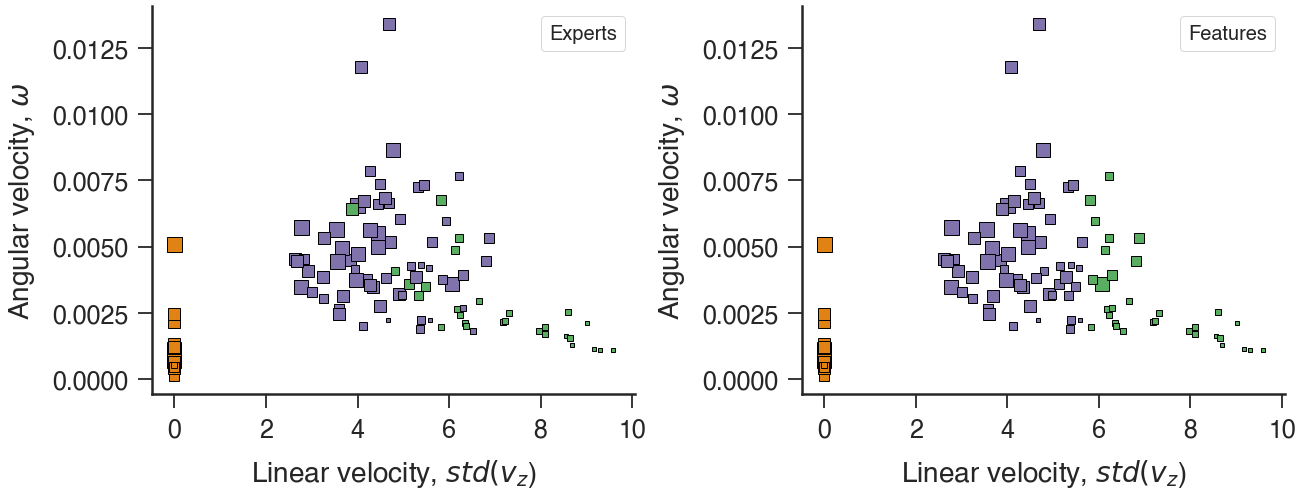

In [26]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nrows=1, ncols=2))

orange_ = "#e08214" #steady/periodic
purple_ = "#8073ac" #chaotic
green_  = "#5aae61" #tumbling

#first panel
for osc, vz, class_, size_ in zip(square_w, square_vz, square_human_class, square_radii):
    if class_==1:
        ax[0].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[0].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[0].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

#second panel
for osc, vz, class_, size_ in zip(square_w, square_vz, square_feat_class, square_radii):
    if class_==1:
        ax[1].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[1].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(osc, vz, 's', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

ax[0].legend(['Experts'], handlelength=0, handletextpad=0, markerscale=0)
ax[1].legend(['Features'], handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Angular velocity, $\omega$')
    ax[i].set_xlabel('Linear velocity, $std(v_z$)')
    
f.tight_layout()

## Square - Complexity-entropy or Fisher-Shannon plane

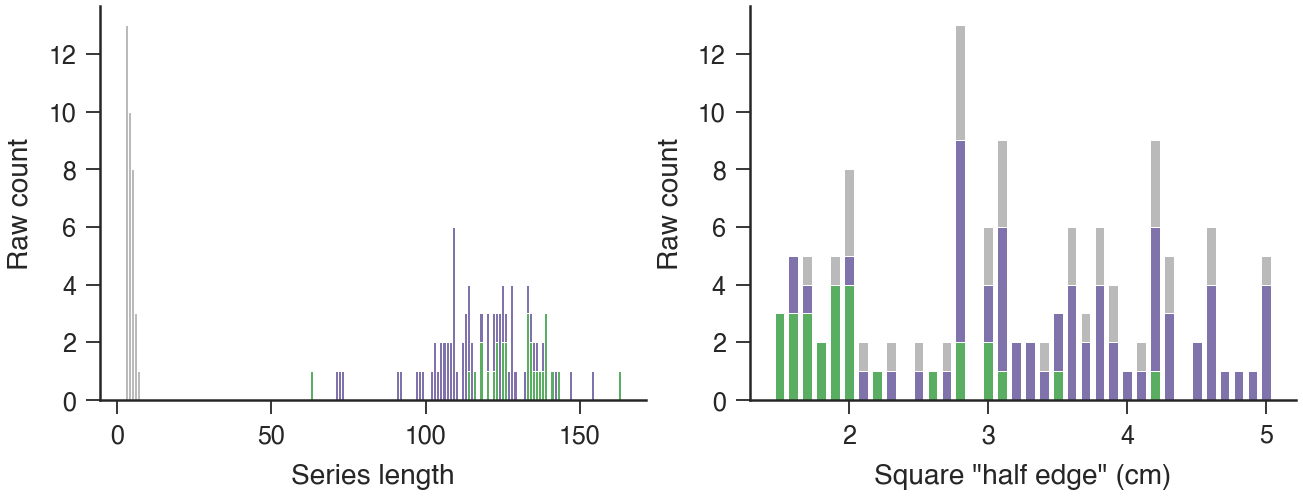

In [533]:
#Series length and falling paper radius histograms

# green  - Tumbling
# purple - Chaotic
# grey   - Steady or periodic behavior

f, ax  = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))
width_ = 1

lengths = np.asarray([len(i) for i in square_trajectories])
x, y    = np.unique([len(i) for i in square_trajectories], return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(square_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=green_)
        elif x_==2:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=purple_)
        else:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=grey_)

        j+=y_
        
ax[0].set_xlabel('Series length')
ax[0].set_ylabel('Raw count')
        
###############################################################################################################
        
lengths = 100*np.asarray([i for i in square_radii]).round(decimals=3)
x, y    = np.unique(lengths, return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(square_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[1].bar(length_, y_, bottom=j, color=green_, width=.07, zorder=0)
        elif x_==2:
            ax[1].bar(length_, y_, bottom=j, color=purple_, width=.07, zorder=1)
        else:
#             pass
            ax[1].bar(length_, y_, bottom=j, color=grey_,  width=.07, zorder=2)

        j+=y_

ax[1].set_xlabel('Square \"half edge\" (cm)')
ax[1].set_ylabel('Raw count')

f.tight_layout()

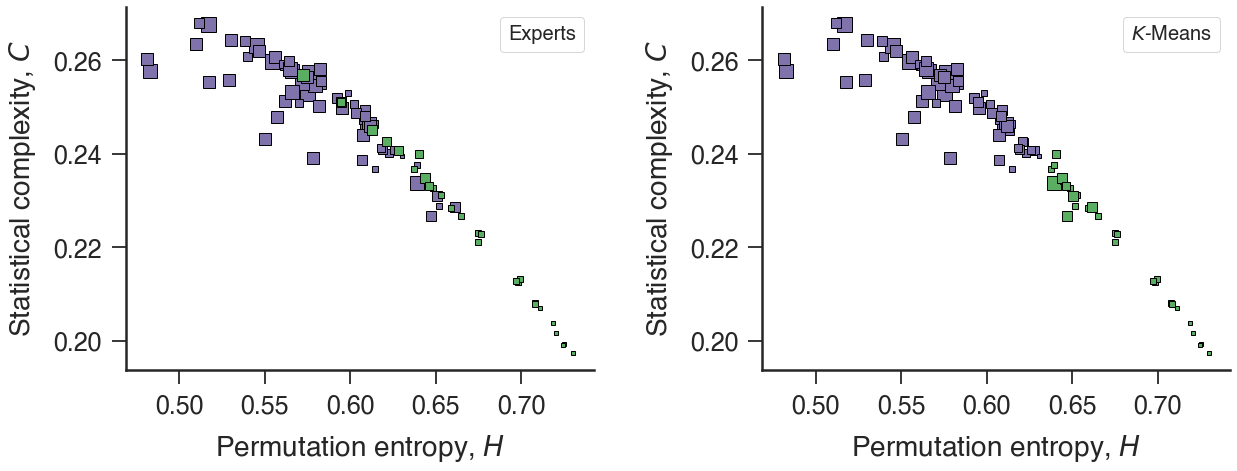

In [27]:
dx_                     = 3
square_ce               = []
square_lengths          = []
square_cluster          = []
square_size             = []
square_human_chaos_tumb = []

for i, st, ts1, ts2, class_, size_ in zip(range(len(square_trajectories)), square_trajectories, 
                                          square_cam1, square_cam2, square_human_class, square_radii):

    if class_==3: #steady or periodic time series
        try:
#             ts = st #3d trajectory time series           
            ts     = np.stack((ts1, ts2), axis=1) #observable area time series

#             np.random.shuffle(ts) #randomize time series 

            p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)

#             h_, c_ = new_plane(ts, dx_)          
#             h_, c_ = fisher_shannon(ts, dx=dx_, multi=True)
#             h_, c_ = ordpy.complexity_entropy(ts2, dx=dx_, probs=False)
            square_ce.append((h_, c_))
        except:
            square_ce.append((0,0))
            
    else: #tumbling or chaotic time series
#         ts = st #3d trajectory time series           
        ts     = np.stack((ts1, ts2), axis=1) #observable area time series

#         np.random.shuffle(ts) #randomize time series

        p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
#         h_, c_ = new_plane(ts, dx_)

#         h_, c_ = fisher_shannon(ts, dx=dx_, multi=True)
#         h_, c_ = ordpy.complexity_entropy(ts2, dx=dx_, probs=False)
        square_ce.append((h_, c_))
        square_lengths.append(len(ts1))
        square_cluster.append((h_, c_))
        square_size.append(size_)
        square_human_chaos_tumb.append(class_)
        
#figure creation
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(scale=.95, nrows=1, ncols=2))
ax    = ax.flatten()

#inset first panel
# axins = inset_axes(ax[0], width="90%", height="100%",
#                    bbox_to_anchor=(.35, .05, .7, .5),
#                    bbox_transform=ax[0].transAxes, loc=3)
# axins.tick_params(length=5, pad=0)

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"

i, j = 0, 0
for (h_, c_), class_, size_ in zip(square_ce, square_human_class, square_radii): #periodic, tumbling and chaotic
    if class_ == 1: #tumbling
        ax[0].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=green_)
#         ax[0].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=orange_)
#         axins.plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=green_) #green is tumbling
    elif class_ == 2: #chaotic
        ax[0].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', label='Chaotic', color=purple_, zorder=0)
#         ax[0].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', label='Chaotic', color=orange_, zorder=0)
#         axins.plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0) #purple is chaotic
    if class_ == 3:
        pass
#         try:
#             ax[0].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=grey_)
#         except:
#             pass        
        
#clustering to generate the second panel data
square_cluster          = np.asarray(square_cluster).reshape(-1,2) #standardizing permutation features
scaler               = StandardScaler()
square_cluster_features = scaler.fit_transform(square_cluster)
square_pred             = KMeans(n_clusters=2, random_state=42).fit(square_cluster_features).labels_ 

for (h_, c_), class_, size_ in zip(square_cluster, square_pred, square_size): #marker size proportional to series length
# for (h_, c_), class_, size_ in zip(square_cluster, square_pred, square_lengths): #marker size proportional to series length
    if class_==0:
        ax[1].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=green_)
    else:
        ax[1].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)    
# ax[1].plot(*ordpy.minimum_complexity_entropy(dx=3, size=100)[25:50].T, '-', color='black')
# ax[1].plot(*ordpy.maximum_complexity_entropy(dx=3, m=20)[25:60].T, '-', color='black')
    
ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)
ax[0].legend(['Experts'], handlelength=0, handletextpad=0, markerscale=0)

for i in range(2):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
f.savefig('figures/final_figures/squareagon-ce-dx:{}-dims:{}.svg'.format(dx_, 2), bbox_inches='tight')

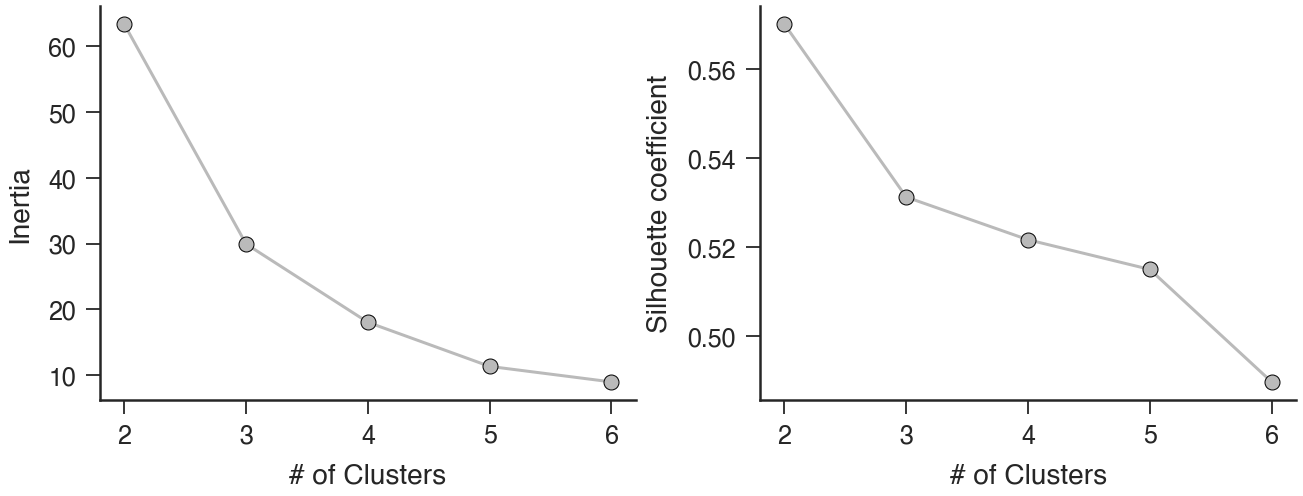

In [113]:
inertia = []
KMEANS  = []
square_cluster          = np.asarray(square_cluster).reshape(-1,2) #standardizing permutation features
scaler               = StandardScaler()
square_cluster_features = scaler.fit_transform(square_cluster)

for k in range(2,7):
    inertia.append(KMeans(n_clusters=k, random_state=42).fit(square_cluster_features).inertia_)
    KMEANS.append(KMeans(n_clusters=k, random_state=42).fit(square_cluster_features))
    # square_pred             = KMeans(n_clusters=2, random_state=42).fit(square_cluster_features).labels_ 
    

silhouette_kmeans = [silhouette_score(square_cluster_features, kmean_.labels_) for kmean_ in KMEANS]

f, ax = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))

ax[0].plot([2,3,4,5,6], inertia, '-o', markersize=15, markeredgecolor='black', color=grey_)
ax[0].set_xlabel('# of Clusters')
ax[0].set_ylabel('Inertia')

ax[1].plot([2,3,4,5,6], silhouette_kmeans, '-o', markersize=15, markeredgecolor='black', color=grey_)
ax[1].set_xlabel('# of Clusters')
ax[1].set_ylabel('Silhouette coefficient')

f.tight_layout()

In [122]:
#Antes de averiguar o resultado, tem de ver a posição dos '3' nas classificações humana e automática. Não é tão trivial assim.
# np.where(square_feat_class==3)[0].flatten()==np.where(square_human_class==3)[0].flatten()

In [57]:
print('Number of time series of falling (squared) papers: ', len(square_human_class))

Number of time series of falling (squared) papers:  127


In [569]:
_, b = np.unique(square_human_class, return_counts=True)
b    = 100*b/b.sum()

print('Relative abundance of tumbling, chaotic and steady(periodic) trajectories (as categorized by experts):')

print('Tumbling         = {}%'.format(b.round(decimals=0)[0]))
print('Chaotic          = {}%'.format(b.round(decimals=0)[1]))
print('Steady/periodic  = {}%'.format(b.round(decimals=0)[2]), '\n')

_, b = np.unique(square_human_class[square_human_class!=3], return_counts=True)
b    = 100*b/b.sum()
print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
print('Tumbling = {}%'.format(b.round(decimals=0)[0]))
print('Chaotic  = {}%'.format(b.round(decimals=0)[1]), '\n')

print('Comparison between our clustering and the clustering based on time series statistics (original approach):')
# # Agreement between the human and the permutation entropy classification (CE)
square_pred_copy = np.where(square_pred==0, 2, square_pred)

# square_pred_copy = np.where(square_pred==1, 2, square_pred)
# square_pred_copy = np.where(square_pred==0, 1, square_pred_copy)

print('Accuracy using permutation entropy (statistics) strategy: ', sum(square_pred_copy==square_human_chaos_tumb)/len(square_pred_copy))
print('Accuracy of the original paper                          : ', sum(square_feat_class[square_feat_class!=3]==square_human_class[square_human_class!=3])/len(square_feat_class[square_feat_class!=3]))

Relative abundance of tumbling, chaotic and steady(periodic) trajectories (as categorized by experts):
Tumbling         = 22.0%
Chaotic          = 50.0%
Steady/periodic  = 28.0% 

Relative abundance of tumbling and chaotic trajectories (as categorized by experts):
Tumbling = 30.0%
Chaotic  = 70.0% 

Comparison between our clustering and the clustering based on time series statistics (original approach):
Accuracy using permutation entropy (statistics) strategy:  0.11956521739130435
Accuracy of the original paper                          :  0.8478260869565217


In [567]:
# SQUARE
# FISHER-SHANNON
# two cameras, several embedding dimensions 
print("TWO CAMERAS")
print("dx=3, ~.815; dx=4, ~.750; dx=5, ~.848; dx=6, ~.815.\n")

# 3d trajectory, several embedding dimensions 
print("3D TRAJECTORY")
print("dx=3, ~.717; dx=4, ~.717; dx=5, ~.717; dx=6, ~.717.")

TWO CAMERAS
dx=3, ~.815; dx=4, ~.750; dx=5, ~.848; dx=6, ~.815.

3D TRAJECTORY
dx=3, ~.717; dx=4, ~.717; dx=5, ~.717; dx=6, ~.717.


In [562]:
# SQUARE
#Complexity-entropy
# Various embedding dimensions (3D trajectory)
print("3D TRAJECTORY")
print("dx = 3, ~.728. dx = 4, ~.739. dx = 5, ~.848. dx = 6, ~.859. dx=7, ~.837")

3D TRAJECTORY
dx = 3, ~.728. dx = 4, ~.739. dx = 5, ~.848. dx = 6, ~.859. dx=7, ~.837


In [566]:
# SQUARE
print("TWO CAMERAS")
# Vários valores de "embedding dimension" para a "two cameras".
print("dx = 3, ~.880. dx = 4, ~.674. dx = 5, ~.793. dx = 6, ~.696.\n")

# Vários valores de "embedding dimension" para a "câmera 1".
print("CAMERA 1")
print("dx = 3, ~.869. dx = 4, ~.739. dx = 5, ~.783. dx = 6, ~.739.\n")

# Vários valores de "embedding dimension" para a "câmera 2".
print("CAMERA 2")
print("dx = 3, ~.826. dx = 4, ~.630. dx = 5, ~.652. dx = 6, ~.652.")

TWO CAMERAS
dx = 3, ~.880. dx = 4, ~.674. dx = 5, ~.793. dx = 6, ~.696.

CAMERA 1
dx = 3, ~.869. dx = 4, ~.739. dx = 5, ~.783. dx = 6, ~.739.

CAMERA 2
dx = 3, ~.826. dx = 4, ~.630. dx = 5, ~.652. dx = 6, ~.652.


In [565]:
#SQUARE

#PJSD-entropy
# Various "embedding dimensions" (two cameras).
print("TWO CAMERAS")
print("dx = 3, ~.739. dx = 4, ~.804. dx = 5, ~.848. dx = 6, ~.880.\n")

#PJSD-entropy
# Various "embedding dimensions" (TIME SERIES).
print("3D TRAJECTORY")
print("dx = 3, ~.707. dx = 4, ~.674. dx = 5, ~.685. dx = 6, ~.696")

TWO CAMERAS
dx = 3, ~.739. dx = 4, ~.804. dx = 5, ~.848. dx = 6, ~.880.

3D TRAJECTORY
dx = 3, ~.707. dx = 4, ~.674. dx = 5, ~.685. dx = 6, ~.696


In [564]:
#SQUARE (Randomized series - means over 100 realizations)

# Various "embedding dimensions" (two cameras). Complexity-entropy.
print("TWO CAMERAS")
print("dx = 3, ~.607(.052). dx = 4, ~.556(.042). dx = 5, ~.544(.035). dx = 6, ~.605(.039). dx = 7, ~.581(.057)\n")

# Various "embedding dimensions" (time series). Complexity-entropy.
print("3D TRAJECTORY")
print("dx = 3, ~.663(.048). dx = 4, ~.695(.038). dx = 5, ~.723(.018). dx = 6, ~.708(.017). dx = 7, ~.726(.006)")

TWO CAMERAS
dx = 3, ~.607(.052). dx = 4, ~.556(.042). dx = 5, ~.544(.035). dx = 6, ~.605(.039). dx = 7, ~.581(.057)

3D TRAJECTORY
dx = 3, ~.663(.048). dx = 4, ~.695(.038). dx = 5, ~.723(.018). dx = 6, ~.708(.017). dx = 7, ~.726(.006)


## 3D - Square

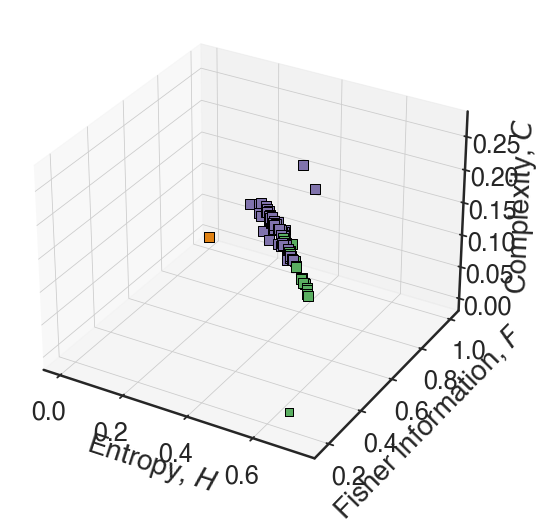

In [81]:
dx_ = 3

square_pe3d                  = []
square_pe3d_space            = []
square_pe3d_human_chaos_tumb = []

for i, ts1, ts2, class_, size_ in zip(range(len(square_trajectories)), square_cam1, 
                                      square_cam2, square_human_class, square_radii):
    if class_==3: #steady or periodic
        try:
            ts     = np.stack((normalize(ts1), normalize(ts2)), axis=1)
            p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
            _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
            square_pe3d.append((h_, f_, c_))
        except:
            square_pe3d.append((np.nan, np.nan))
            
    else: #chaotic or tumbling
        ts     = np.stack((normalize(ts1), normalize(ts2)), axis=1)
        p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, f_ = fisher_shannon(p, dx=dx_, probs=True, multi=True)
        _, c_  = ordpy.complexity_entropy(p, dx=dx_, probs=True)
        square_pe3d.append((h_, f_, c_))
        square_pe3d_space.append((h_, f_, c_))
        square_pe3d_human_chaos_tumb.append(class_)

###################################################################        
f  = plt.figure()
ax = f.add_subplot(111, projection='3d')


orange_ = "#e08214" #3
purple_ = "#8073ac" #2
green_  = "#5aae61" #1
#(h_, f_, c_)
# for (x_, y_, z_), class_ in zip(square_pe3d, square_feat_class): 
for (x_, y_, z_), class_ in zip(square_pe3d, square_human_class):
    if class_ == 1: #tumbling
        ax.scatter(x_, y_, z_, marker='s', s=100, color=green_, edgecolor='black')
        ax.plot(h_, c_, '.', marker='s', markersize=8, markeredgecolor='black', color=green_, zorder=0)
    elif class_ == 2: #chaotic
        ax.scatter(x_, y_, z_, marker='s', s=100, color=purple_, edgecolor='black')
    if class_ == 3:
        try:
            ax.scatter(x_, y_, z_, marker='s', s=100, color=orange_, edgecolor='black', zorder=0)
        except:
            pass

ax.set_xlabel('Entropy, $H$')
ax.set_ylabel('Fisher information, $F$')
ax.set_zlabel('Complexity, $C$')



#calculation to generate second panel data
square_pe3d_space = np.asarray(square_pe3d_space).reshape(-1,3)
square_pe3d_pred  = KMeans(n_clusters=2, random_state=42).fit(square_pe3d_space).labels_ 


f.tight_layout()

In [102]:
square_pe3d_pred_copy_plus_1 = square_pe3d_pred.copy()+1

sum(square_pe3d_human_chaos_tumb==square_pe3d_pred_copy_plus_1)/len(square_pe3d_pred_copy_plus_1)

0.18478260869565216

In [103]:
square_pe3d_pred_copy = np.where(square_pe3d_pred==0, 2, square_pe3d_pred)

sum(square_pe3d_human_chaos_tumb==square_pe3d_pred_copy)/len(square_pe3d_pred_copy)

0.8152173913043478

In [35]:
# pe3d_plane = np.asarray(pe3d_plane).reshape(-1, 3)
# Y_pred     = KMeans(n_clusters=2, random_state=42).fit(pe3d_plane).labels_

# f  = plt.figure()
# ax = f.add_subplot(111, projection='3d')


# #(h_, f_, c_)
# for (h_, f_, c_), class_ in zip(pe3d_plane, Y_pred): 
#     if class_==0:
#         ax.scatter(h_, f_, c_, marker='o', s=100, edgecolor='black', color='grey', zorder=0)
#     else:
#         ax.scatter(h_, f_, c_, marker='*', s=100, color='blue')
        
# ax.set_ylabel('Fisher information, $F$')
# ax.set_xlabel('Entropy, $H$')

# f.tight_layout()

# Y_pred_full = square_feat_class.copy()
# y_pred_sub  = np.where(Y_pred==0, 2, Y_pred)
# # y_pred_sub  = np.where(y_pred_sub==1, 0, y_pred_sub)

# k = 0
# for i, j in zip(square_feat_class, range(len(square_feat_class))):
#     if i==3:
#         pass
#     else:
#         Y_pred_full[j] = y_pred_sub[k]
#         k += 1

# sum(square_feat_class==square_human_class)/len(square_human_class)

# sum(Y_pred_full==square_human_class)/len(square_human_class)

0.4067796610169492

# Cross  Analysis

In [28]:
#loading cleaned trajectories and some features.
cross_trajectories, cross_cam1, cross_cam2, cross_radii, cross_width, cross_conditions, _  = trajectory_cleaning('Cross')
cross_dx, cross_dy, cross_dz, cross_pathlen, cross_time, cross_w, cross_vz                 = original_features(cross_trajectories, cross_cam1, cross_cam2)

/home/arthur/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [29]:
#Classifications
cross_human_class = scipy.io.loadmat('classification/humanClassification{}.mat'.format('Cross'))['behaviourHuman'][0]
cross_feat_class  = scipy.io.loadmat('classification/data{}Classified.mat'.format('Cross'))['behaviourAuto'].flatten()

#Mapping from integer to behavior class
# 1 - Tumbling
# 2 - Chaotic
# 3 - Steady or periodic behavior

In [30]:
# for a, b, c, d, e, f, g,  k in zip(scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['dx'].flatten()==np.asarray(cross_dx), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['dy'].flatten()==np.asarray(cross_dy), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['dz'].flatten()==np.asarray(cross_dz), 
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['pathLength'].flatten(), cross_pathlen,
#                             scipy.io.loadmat('classification/data{}Classified.mat'.format("Cross"))['time'].flatten(), cross_time,
#                             range(len(cross_dx))):

#     print(a, b, c, abs(d-e)<0.0001, abs(f-g)<0.0001, k)

## Cross - Original features plane

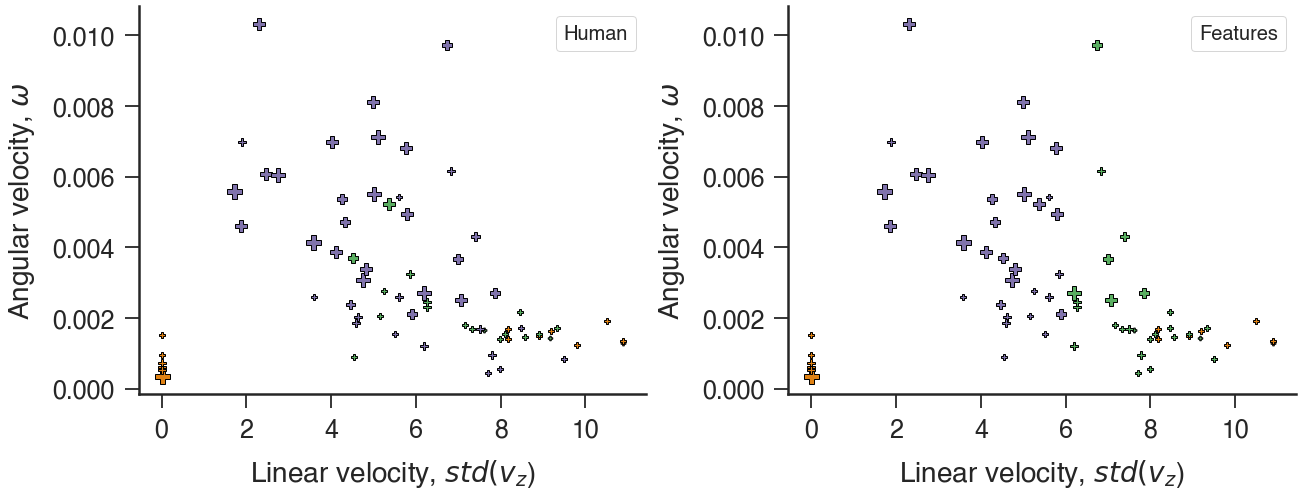

In [31]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(nrows=1, ncols=2))

#first panel
for osc, vz, class_, size_ in zip(cross_w, cross_vz, cross_human_class, cross_radii):
    if class_==1:
        ax[0].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[0].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[0].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

#second panel
for osc, vz, class_, size_ in zip(cross_w, cross_vz, cross_feat_class, cross_radii):
    if class_==1:
        ax[1].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=green_)
    elif class_==2:
        ax[1].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=purple_)
    else:
        ax[1].plot(osc, vz, 'P', markersize=300*size_, markeredgecolor='black', color=orange_)
#         pass

ax[0].legend(['Human'], handlelength=0, handletextpad=0, markerscale=0)
ax[1].legend(['Features'], handlelength=0, handletextpad=0, markerscale=0)
for i in range(2):
    ax[i].set_ylabel('Angular velocity, $\omega$')
    ax[i].set_xlabel('Linear velocity, $std(v_z$)')
    
f.tight_layout()

## Cross - Complexity-entropy or Fisher-Shannon plane

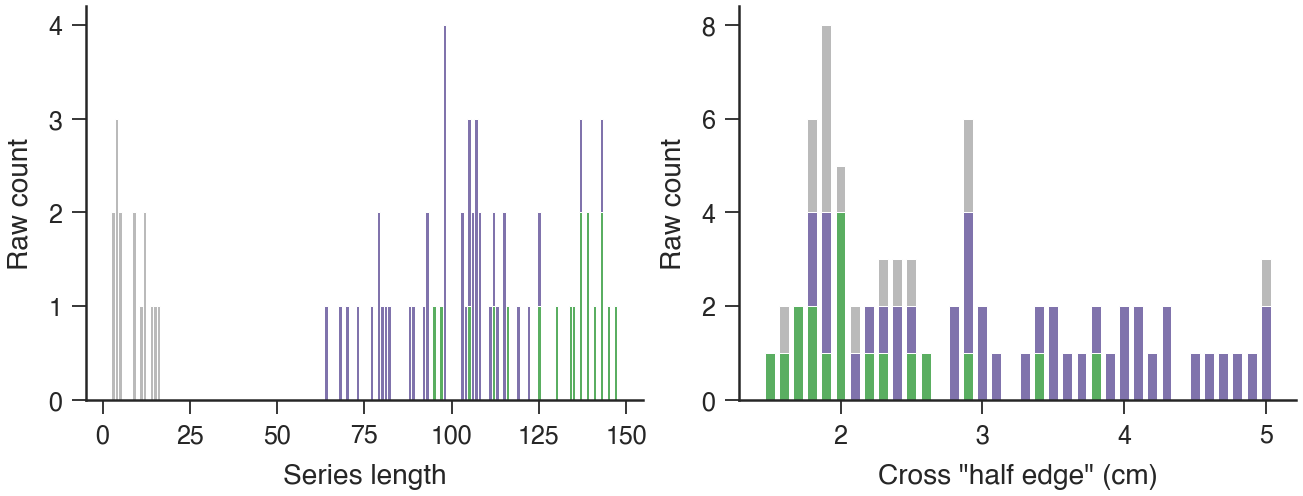

In [32]:
cross_lengths.append(len(ts1))
#Series length and falling paper radius histograms

# green  - Tumbling
# purple - Chaotic
# grey   - Steady or periodic behavior

f, ax  = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))
width_ = 1

lengths = np.asarray([len(i) for i in cross_trajectories])
x, y    = np.unique([len(i) for i in cross_trajectories], return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(cross_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=green_)
        elif x_==2:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=purple_)
        else:
            ax[0].bar(length_, y_, bottom=j, width=width_, color=grey_)

        j+=y_
        
ax[0].set_xlabel('Series length')
ax[0].set_ylabel('Raw count')
        
###############################################################################################################
        
lengths = 100*np.asarray([i for i in cross_radii]).round(decimals=3)
x, y    = np.unique(lengths, return_counts=True)

for length_, i in zip(x, range(len(x))):
    xx, yy = np.unique(cross_human_class[np.argwhere(lengths==length_).flatten()], return_counts=True)
    
    j = 0
    for x_, y_ in zip(xx, yy):
        if x_==1:
            ax[1].bar(length_, y_, bottom=j, color=green_, width=.07, zorder=0)
        elif x_==2:
            ax[1].bar(length_, y_, bottom=j, color=purple_, width=.07, zorder=1)
        else:
#             pass
            ax[1].bar(length_, y_, bottom=j, color=grey_,  width=.07, zorder=2)

        j+=y_

ax[1].set_xlabel('Cross \"half edge\" (cm)')
ax[1].set_ylabel('Raw count')

f.tight_layout()

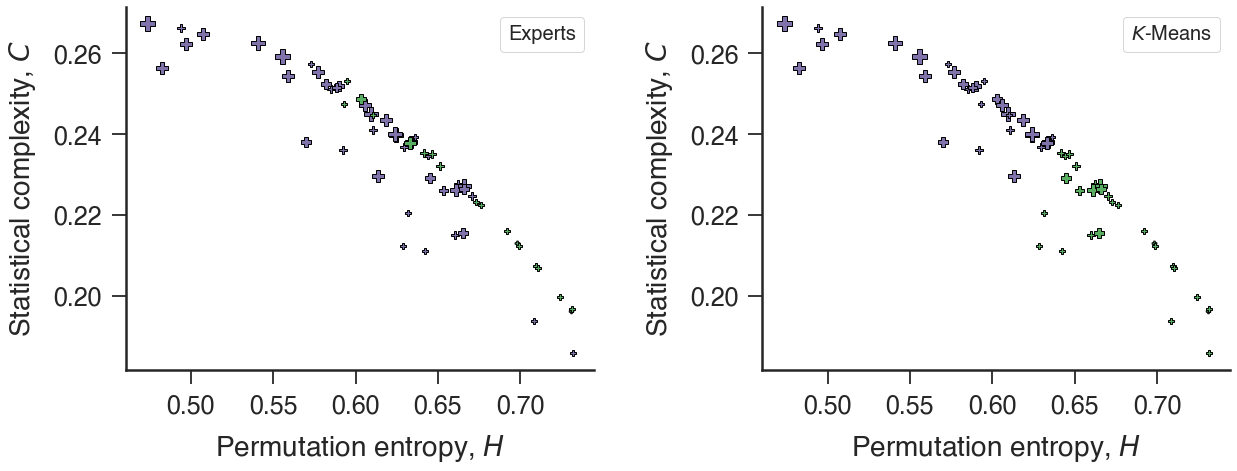

In [112]:
dx_                    = 3
cross_ce               = []
cross_cluster          = []
cross_size             = []
cross_human_chaos_tumb = []
cross_lengths          = []

for i, st, ts1, ts2, class_, size_ in zip(range(len(cross_trajectories)), cross_trajectories, 
                                          cross_cam1, cross_cam2, cross_human_class, cross_radii):

    if class_==3: #steady or periodic time series
        try:
#             ts = st #3d trajectory time series           
            ts     = np.stack((ts1, ts2), axis=1) #observable area time series

#             np.random.shuffle(ts) #randomize time series 

            p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
            h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)

#             h_, c_ = new_plane(ts, dx_)          
#             h_, c_ = fisher_shannon(ts, dx=dx_, multi=True)
#             h_, c_ = ordpy.complexity_entropy(ts2, dx=dx_, probs=False)
            cross_ce.append((h_, c_))
        except:
            cross_ce.append((0,0))
            
    else: #tumbling or chaotic time series
#         ts = st #3d trajectory time series           
        ts     = np.stack((ts1, ts2), axis=1) #observable area time series

#         np.random.shuffle(ts) #randomize time series

        p      = multi_permutation_entropy(ts, dx=dx_, return_probs=True)
        h_, c_ = ordpy.complexity_entropy(p, dx=dx_, probs=True)
#         h_, c_ = new_plane(ts, dx_)

#         h_, c_ = fisher_shannon(ts, dx=dx_, multi=True)
#         h_, c_ = ordpy.complexity_entropy(ts2, dx=dx_, probs=False)
        cross_ce.append((h_, c_))
        cross_lengths.append(len(ts1))
        cross_cluster.append((h_, c_))
        cross_size.append(size_)
        cross_human_chaos_tumb.append(class_)
        
#figure creation
f, ax = plt.subplots(nrows=1, ncols=2, figsize=stdfigsize(scale=.95, nrows=1, ncols=2))
ax    = ax.flatten()

#inset first panel
# axins = inset_axes(ax[0], width="90%", height="100%",
#                    bbox_to_anchor=(.35, .05, .7, .5),
#                    bbox_transform=ax[0].transAxes, loc=3)
# axins.tick_params(length=5, pad=0)

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"

i, j = 0, 0
for (h_, c_), class_, size_ in zip(cross_ce, cross_human_class, cross_radii): #periodic, tumbling and chaotic
    if class_ == 1: #tumbling
        ax[0].plot(h_, c_, '.', marker='P', markersize=300*size_, markeredgecolor='black', color=green_)
#         ax[0].plot(h_, c_, '.', marker='P', markersize=300*size_, markeredgecolor='black', color=orange_)
#         axins.plot(h_, c_, '.', marker='P', markersize=300*size_, markeredgecolor='black', color=green_) #green is tumbling
    elif class_ == 2: #chaotic
        ax[0].plot(h_,c_,  '.', marker='P', markersize=300*size_, markeredgecolor='black', label='Chaotic', color=purple_, zorder=0)
#         ax[0].plot(h_,c_,  '.', marker='P', markersize=300*size_, markeredgecolor='black', label='Chaotic', color=orange_, zorder=0)
#         axins.plot(h_,c_,  '.', marker='P', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0) #purple is chaotic
    if class_ == 3:
        pass
#         try:
#             ax[0].plot(h_,c_,  '.', marker='P', markersize=300*size_, markeredgecolor='black', color=grey_)
#         except:
#             pass        
        
#clustering to generate the second panel data
cross_cluster          = np.asarray(cross_cluster).reshape(-1,2) #standardizing permutation features
scaler                 = StandardScaler()
cross_cluster_features = scaler.fit_transform(cross_cluster)
cross_pred             = KMeans(n_clusters=2, random_state=42).fit(cross_cluster_features).labels_ 

for (h_, c_), class_, size_ in zip(cross_cluster, cross_pred, cross_size): #marker size proportional to series length
# for (h_, c_), class_, size_ in zip(cross_cluster, cross_pred, cross_lengths): #marker size proportional to series length
    if class_==1:
        ax[1].plot(h_, c_, '.', marker='P', markersize=300*size_, markeredgecolor='black', color=green_)
    else:
        ax[1].plot(h_,c_,  '.', marker='P', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)    
        
# ax[1].plot(*ordpy.minimum_complexity_entropy(dx=3, size=100)[25:50].T, '-', color='black')
# ax[1].plot(*ordpy.maximum_complexity_entropy(dx=3, m=20)[25:60].T, '-', color='black')
    
ax[1].legend(['$K$-Means'], handlelength=0, handletextpad=0, markerscale=0)
ax[0].legend(['Experts'], handlelength=0, handletextpad=0, markerscale=0)

for i in range(2):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

f.tight_layout(w_pad=5)
# f.savefig('figures/final_figures/cross-ce-dx:{}-dims:{}.svg'.format(dx_, 2), bbox_inches='tight')

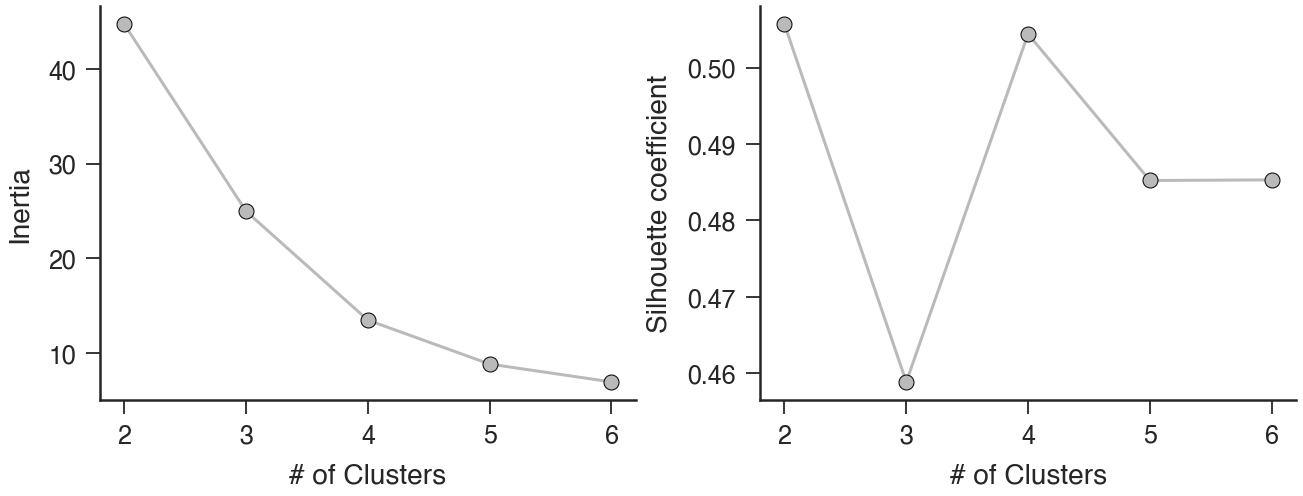

In [109]:
inertia = []
KMEANS  = []
cross_cluster          = np.asarray(cross_cluster).reshape(-1,2) #standardizing permutation features
scaler               = StandardScaler()
cross_cluster_features = scaler.fit_transform(cross_cluster)

for k in range(2,7):
    inertia.append(KMeans(n_clusters=k, random_state=42).fit(cross_cluster_features).inertia_)
    KMEANS.append(KMeans(n_clusters=k, random_state=42).fit(cross_cluster_features))
    # cross_pred             = KMeans(n_clusters=2, random_state=42).fit(cross_cluster_features).labels_ 
    

silhouette_kmeans = [silhouette_score(cross_cluster_features, kmean_.labels_) for kmean_ in KMEANS]

f, ax = plt.subplots(ncols=2, figsize=stdfigsize(ncols=2))

ax[0].plot([2,3,4,5,6], inertia, '-o', markersize=15, markeredgecolor='black', color=grey_)
ax[0].set_xlabel('# of Clusters')
ax[0].set_ylabel('Inertia')

ax[1].plot([2,3,4,5,6], silhouette_kmeans, '-o', markersize=15, markeredgecolor='black', color=grey_)
ax[1].set_xlabel('# of Clusters')
ax[1].set_ylabel('Silhouette coefficient')

f.tight_layout()

In [132]:
#Antes de averiguar o resultado, tem de ver a posição dos '3' nas classificações humana e automática. Não é tão trivial assim.
# np.where(cross_feat_class==3)[0].flatten()==np.where(cross_human_class==3)[0].flatten()

In [287]:
# print('Range of time series lengths of falling papers: ', min([len(i) for i in cross_trajectories]),',', max([len(i) for i in cross_trajectories]))

# print('Number of time series of falling (cross like) papers: ', len(cross_human_class[cross_human_class!=3]))

In [580]:
_, b = np.unique(cross_human_class, return_counts=True)
b    = 100*b/b.sum()

print('Relative abundance of tumbling, chaotic and steady(periodic) trajectories (as categorized by experts):')

print('Tumbling         = {}%'.format(b.round(decimals=0)[0]))
print('Chaotic          = {}%'.format(b.round(decimals=0)[1]))
print('Steady/periodic  = {}%'.format(b.round(decimals=0)[2]), '\n')

_, b = np.unique(cross_human_class[cross_human_class!=3], return_counts=True)
b    = 100*b/b.sum()
print('Relative abundance of tumbling and chaotic trajectories (as categorized by experts):')
print('Tumbling = {}%'.format(b.round(decimals=0)[0]))
print('Chaotic  = {}%'.format(b.round(decimals=0)[1]), '\n')

print('Comparison between our clustering and the clustering based on time series statistics (original approach):')
cross_pred_copy = np.where(cross_pred==0, 2, cross_pred)

# cross_pred_copy = np.where(cross_pred==1, 2, cross_pred)
# cross_pred_copy = np.where(cross_pred==0, 1, cross_pred_copy)

print('Accuracy using permutation entropy (statistics) strategy: ', sum(cross_human_chaos_tumb==cross_pred_copy)/len(cross_pred_copy))
print('Accuracy of the original paper                          : ', sum(cross_feat_class[cross_feat_class!=3]==cross_human_class[cross_human_class!=3])/len(cross_feat_class[cross_feat_class!=3]))

Relative abundance of tumbling, chaotic and steady(periodic) trajectories (as categorized by experts):
Tumbling         = 24.0%
Chaotic          = 55.0%
Steady/periodic  = 20.0% 

Relative abundance of tumbling and chaotic trajectories (as categorized by experts):
Tumbling = 31.0%
Chaotic  = 69.0% 

Comparison between our clustering and the clustering based on time series statistics (original approach):
Accuracy using permutation entropy (statistics) strategy:  0.7627118644067796
Accuracy of the original paper                          :  0.6440677966101694


In [38]:
# CROSS
# FISHER-SHANNON
# "two cameras", several embedding dimensions 
print("TWO CAMERAS")
print("dx=3, ~.559; dx=4, ~.559; dx=5, ~.814; dx=6, ~.797.\n")

# 3d trajectory, several embedding dimensions 
print("3D TRAJECTORY")
print("dx=3, ~.712; dx=4, ~.712; dx=5, ~.712; dx=6, ~.712.")

TWO CAMERAS
dx=3, ~.559; dx=4, ~.559; dx=5, ~.814; dx=6, ~.797.

3D TRAJECTORY
dx=3, ~.712; dx=4, ~.712; dx=5, ~.712; dx=6, ~.712.


In [39]:
#CROSS
#Complexity-entropy, "two cameras"
print("TWO CAMERAS")
print("dx = 3, ~.661. dx = 4, ~.661. dx = 5, ~.661. dx = 6, ~.627.\n")

# Vários valores de "embedding dimension" para a "câmera 1".
print("CAMERA 1")
print("dx = 3, ~.678. dx = 4, ~.508. dx = 5, ~.712. dx = 6, ~.661.\n")

# Vários valores de "embedding dimension" para a "câmera 2".
print("CAMERA 2")
print("dx = 3, ~.695. dx = 4, ~.559. dx = 5, ~.763. dx = 6, ~.763.")

TWO CAMERAS
dx = 3, ~.661. dx = 4, ~.661. dx = 5, ~.661. dx = 6, ~.627.

CAMERA 1
dx = 3, ~.678. dx = 4, ~.508. dx = 5, ~.712. dx = 6, ~.661.

CAMERA 2
dx = 3, ~.695. dx = 4, ~.559. dx = 5, ~.763. dx = 6, ~.763.


In [301]:
# JS-entropy
# Various "embedding dimensions" (two cameras).
print("TWO CAMERAS")
print("dx = 3, ~.780. dx = 4, ~.814. dx = 5, ~.814. dx = 6, ~.864.\n")

# JS-entropy
# Various "embedding dimensions" (TIME SERIES).
print("3D TRAJECTORY")
print("dx = 3, ~.695. dx = 4, ~.780. dx = 5, ~.780. dx = 6, ~.780.")

TWO CAMERAS
dx = 3, ~.678. dx = 4, ~.814. dx = 5, ~.814. dx = 6, ~.864.

TIME SERIES
dx = 3, ~.695. dx = 4, ~.780. dx = 5, ~.780. dx = 6, ~.780.


In [581]:
#CROSS

#Complexity-entropy
# Vários valores de "embedding dimension" para 3D trajectory
print("3D TRAJECTORY")
print("dx = 3, ~.695. dx = 4, ~.763. dx = 5, ~.763. dx = 6, ~.678. dx=7, ~.695.")

3D TRAJECTORY
dx = 3, ~.695. dx = 4, ~.763. dx = 5, ~.763. dx = 6, ~.678. dx=7, ~.695


In [40]:
#CROSS (Randomized series - means over 100 realizations)

# Various "embedding dimensions" (two cameras). Complexity-entropy.
print("TWO CAMERAS")
print("dx = 3, ~.576(.052). dx = 4, ~.554(.040). dx = 5, ~.618(.063). dx = 6, ~.679(.055). dx = 7, ~.591(.030).\n")

# Various "embedding dimensions" (time series). Complexity-entropy.
print("3D TRAJECTORY")
print("dx = 3, ~.614(.052). dx = 4, ~.609(.046). dx = 5, ~.586(.044). dx = 6, ~.529(.023). dx = 7, ~.613(.031).")

TWO CAMERAS
dx = 3, ~.576(.052). dx = 4, ~.554(.040). dx = 5, ~.618(.063). dx = 6, ~.679(.055). dx = 7, ~.591(.030).

3D TRAJECTORY
dx = 3, ~.614(.052). dx = 4, ~.609(.046). dx = 5, ~.586(.044). dx = 6, ~.529(.023). dx = 7, ~.613(.031).


# Figures

NameError: name 'hex_ce' is not defined

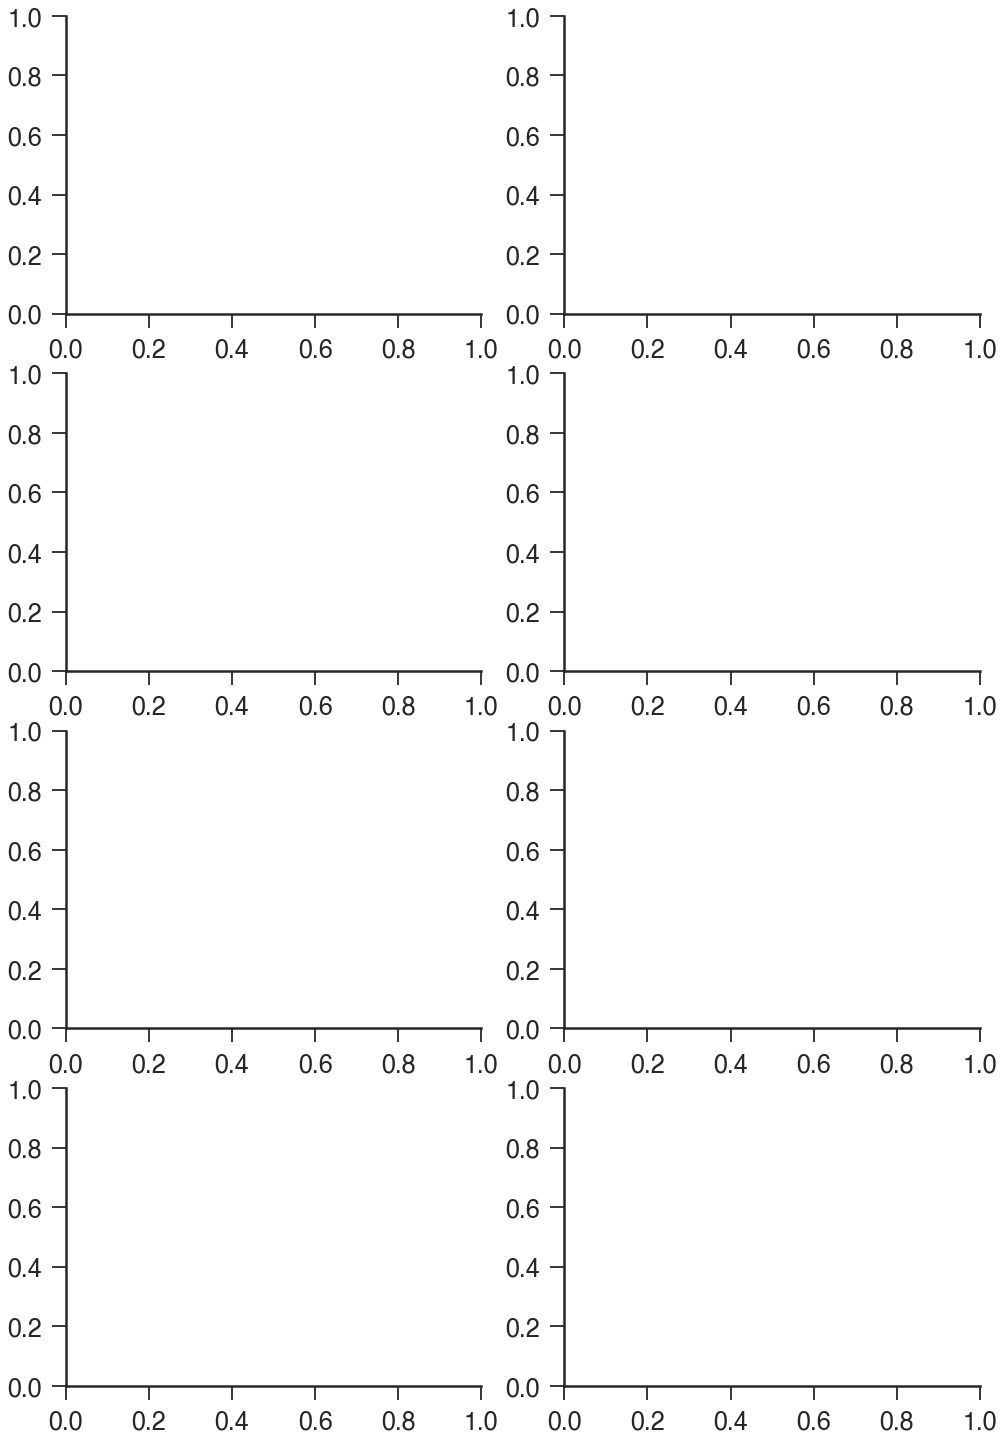

In [34]:
f, ax = plt.subplots(nrows=4, ncols=2, figsize=stdfigsize(scale=.9, nrows=4, ncols=2))
ax    = ax.flatten()

orange_ = "#e08214"
purple_ = "#8073ac"
green_  = "#5aae61"
grey_   = "#bababa"

data_plots_left = [
                [circle_ce, circle_human_class, 300*np.asarray(circle_radii)],
                [hex_ce, hex_human_class, 300*np.asarray(hex_radii)],
                [square_ce, square_human_class, 300*np.asarray(square_radii)],
                [cross_ce, cross_human_class, np.sqrt(10000*np.multiply(cross_radii,cross_width)*30)]
                ]
                
data_plots_right = [
                [circle_cluster, circle_pred_copy, 300*np.asarray(circle_size)],
                [hex_cluster, hex_pred_copy, 300*np.asarray(hex_size)],
                [square_cluster, square_pred_copy, 300*np.asarray(square_size)],
                [cross_cluster, cross_pred_copy, np.sqrt(np.asarray(cross_size)*30)]
                ]

plot_markers = ['o', 'h', 's', 'P']

for data, marker_, ax_ in zip(data_plots_left, plot_markers, ax[0::2]):
    #inset
    axins = inset_axes(ax_, width="90%", height="100%",
                       bbox_to_anchor=(.35, .05, .7, .5),
                       bbox_transform=ax_.transAxes, loc=3)
    axins.tick_params(length=5, pad=0)
    
    i, j, k = 0, 0, 0
    for (h_, c_), class_, size_ in zip(data[0], data[1], data[2]): #periodic, tumbling and chaotic
        if class_ == 1: #tumbling
            if not i==0:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=orange_)
                axins.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=green_)
            else:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=orange_, label='Tumbling or\nchaotic')
                axins.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=green_, label='Tumbling')
                i+=1
        elif class_ == 2: #chaotic
            if not j==0:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=orange_, zorder=0)
                axins.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=purple_, zorder=0)
            else:
                axins.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
                j+=1
        if class_ == 3:
            if not k==0:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=grey_)
            else:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=grey_, label='Steady')
                k+=1
    
    if not marker_=='h':
        #legend        
        axlgnd = ax_.legend(loc=[.01,.76], handletextpad=0, numpoints=1)
        axlgnd.legendHandles[0]._legmarker.set_markersize(12)
        axlgnd.legendHandles[1]._legmarker.set_markersize(12)

        #inset legend
        axins_lgnd = axins.legend(loc='lower left', handletextpad=0)
        axins_lgnd.legendHandles[0]._legmarker.set_markersize(12)
        axins_lgnd.legendHandles[1]._legmarker.set_markersize(12)
    else:
        handles, labels = ax_.get_legend_handles_labels()
        axlgnd = ax_.legend(handles[::-1], labels[::-1],  loc=[.01,.76], handletextpad=0, numpoints=1)
        axlgnd.legendHandles[0]._legmarker.set_markersize(12)
        axlgnd.legendHandles[1]._legmarker.set_markersize(12)

        handles, labels = axins.get_legend_handles_labels()
        axins_lgnd = axins.legend(handles[::-1], labels[::-1], handletextpad=0, numpoints=1)
        axins_lgnd.legendHandles[0]._legmarker.set_markersize(12)
        axins_lgnd.legendHandles[1]._legmarker.set_markersize(12)

    axins.annotate('Experts', (.75, .8),va='center',ha='center', xycoords='axes fraction', fontsize=20,
                   bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    
        
# #second column
for data, marker_, ax_ in zip(data_plots_right, plot_markers, ax[1::2]):    
    i, j = 0, 0
    for (h_, c_), class_, size_ in zip(data[0], data[1], data[2]):
        if class_==2:
            if not i==0:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=purple_, zorder=0)
            else:
                ax_.plot(h_, c_, '.', marker=marker_, markersize=size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
                i+=1
        else:
            if not j==0:
                ax_.plot(h_,c_,  '.', marker=marker_, markersize=size_, markeredgecolor='black', color=green_)    
            else:
                ax_.plot(h_,c_,  '.', marker=marker_, markersize=size_, markeredgecolor='black', label='Tumbling', color=green_)    
                j+=1
                
    if not marker_=='o':
        #legend        
        axlgnd = ax_.legend(handletextpad=0, numpoints=1)
        axlgnd.legendHandles[0]._legmarker.set_markersize(12)
        axlgnd.legendHandles[1]._legmarker.set_markersize(12)
    else:
        handles, labels = ax_.get_legend_handles_labels()
        axlgnd = ax_.legend(handles[::-1], labels[::-1], handletextpad=0, numpoints=1)
        axlgnd.legendHandles[0]._legmarker.set_markersize(12)
        axlgnd.legendHandles[1]._legmarker.set_markersize(12)
                    
#     axlgnd = ax_.legend(handletextpad=0, numpoints=1)
#     axlgnd.legendHandles[0]._legmarker.set_markersize(12)
#     axlgnd.legendHandles[1]._legmarker.set_markersize(12)

    ax_.annotate('$K$-Means', (.875, .695),va='center',ha='center', xycoords='axes fraction', fontsize=20,
               bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    

for i in range(0, 8):
    ax[i].set_ylabel('Statistical complexity, $C$')
    ax[i].set_xlabel('Permutation entropy, $H$')

    
for (i, ax_), x_ in zip(list(enumerate(ax)), [-.24,-.27]*4):
    ax_.annotate('(' + string.ascii_lowercase[i] + ')', (x_, 1.07),
                 xycoords='axes fraction',
                 fontsize=30,
                 )
    
f.tight_layout(w_pad=3)
f.savefig('figures/final_figures/fig1.pdf', dpi=300, bbox_inches='tight')

In [160]:
# f, ax = plt.subplots(nrows=4, ncols=2, figsize=stdfigsize(scale=.9, nrows=4, ncols=2))
# ax    = ax.flatten()

# orange_ = "#e08214"
# purple_ = "#8073ac"
# green_  = "#5aae61"
# grey_   = "#bababa"

# #first panel
# axins = inset_axes(ax[0], width="90%", height="100%",
#                    bbox_to_anchor=(.35, .05, .7, .5),
#                    bbox_transform=ax[0].transAxes, loc=3)
# axins.tick_params(length=5, pad=0)

# i, j, k = 0, 0, 0
# for (h_, c_), class_, size_ in zip(circle_ce, circle_human_class, circle_radii): #periodic, tumbling and chaotic
#     if class_ == 1: #tumbling
#         if not i==0:
#             ax[0].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=orange_)
#             axins.plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_)
#         else:
#             i+=1
#             ax[0].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=orange_, label='Tumbling or\nchaotic')
#             axins.plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_, label='Tumbling')
#     elif class_ == 2: #chaotic
#         if not j==0:
#             ax[0].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=orange_, zorder=0)
#             axins.plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             j+=1
#             axins.plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
#     if class_ == 3:
#         if not k==0:
#             ax[0].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=grey_)
#         else:
#             k+=1
#             ax[0].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=grey_, label='Steady')
            
# # ax[0].legend(loc=[.01,.76], handletextpad=0)
# lgnd = ax[0].legend(loc=[.01,.76], handletextpad=0, numpoints=1)
# #change the marker size manually for both lines
# lgnd.legendHandles[0]._legmarker.set_markersize(12)
# lgnd.legendHandles[1]._legmarker.set_markersize(12)

# axins.legend(handletextpad=0)
# axins.annotate('Experts', (.75, .8),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    
        
    
# #second panel
# i, j = 0, 0
# for (h_, c_), class_, size_ in zip(circle_cluster, circle_pred, circle_size):
#     if class_==0:
#         if not i==0:
#             ax[1].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             i+=1
#             ax[1].plot(h_, c_, '.', marker='o', markersize=300*size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
#     else:
#         if not j==0:
#             ax[1].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', color=green_)    
#         else:
#             j+=1
#             ax[1].plot(h_,c_,  '.', marker='o', markersize=300*size_, markeredgecolor='black', label='Tumbling', color=green_)    

# # ax[1].legend(handletextpad=0)
# # Plot legend.
# lgnd = ax[1].legend(handletextpad=0, numpoints=1)
# #change the marker size manually for both lines
# lgnd.legendHandles[0]._legmarker.set_markersize(12)
# lgnd.legendHandles[1]._legmarker.set_markersize(12)
# ax[1].annotate('$K$-Means', (.865, .715),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    

# ###################################################################################################################
# #third panel
# axins = inset_axes(ax[2], width="90%", height="100%",
#                    bbox_to_anchor=(.35, .05, .7, .5),
#                    bbox_transform=ax[2].transAxes, loc=3)
# axins.tick_params(length=5, pad=0)

# i, j, k = 0, 0, 0
# for (h_, c_), class_, size_ in zip(hex_ce, hex_human_class, hex_radii): #periodic, tumbling and chaotic
#     if class_ == 1: #tumbling
#         if not i==0:
#             ax[2].plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=orange_)
#             axins.plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=green_)
#         else:
#             i+=1
#             ax[2].plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=orange_, label='Tumbling or\nchaotic')
#             axins.plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=green_, label='Tumbling')
#     elif class_ == 2: #chaotic
#         if not j==0:
#             ax[2].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=orange_, zorder=0)
#             axins.plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             j+=1
#             axins.plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
#     if class_ == 3:
#         if not k==0:
#             ax[2].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=grey_)
#         else:
#             k+=1
#             ax[2].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=grey_, label='Steady')
            
# ax[2].legend(loc=[.01,.76], handletextpad=0)
# axins.legend(handletextpad=0)

# lgnd = ax[2].legend(handletextpad=0, numpoints=1)
# #change the marker size manually for both lines
# lgnd.legendHandles[0]._legmarker.set_markersize(12)
# lgnd.legendHandles[1]._legmarker.set_markersize(12)


# lgnd = axins.legend(handletextpad=0, numpoints=1)
# lgnd.legendHandles[0]._legmarker.set_markersize(12)
# lgnd.legendHandles[1]._legmarker.set_markersize(12)
# axins.annotate('Experts', (.75, .8),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    
# # ax[1].annotate('$K$-Means', (.865, .715),va='center',ha='center', xycoords='axes fraction', fontsize=20,
# #                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})   
        
    
# #fourth panel
# i, j = 0, 0
# for (h_, c_), class_, size_ in zip(hex_cluster, hex_pred, hex_size):
#     if class_==0:
#         if not i==0:
#             ax[3].plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             i+=1
#             ax[3].plot(h_, c_, '.', marker='h', markersize=300*size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
#     else:
#         if not j==0:
#             ax[3].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', color=green_)    
#         else:
#             j+=1
#             ax[3].plot(h_,c_,  '.', marker='h', markersize=300*size_, markeredgecolor='black', label='Tumbling', color=green_)    


# # Plot legend.
# # ax[3].legend(handletextpad=0)
# lgnd = ax[3].legend(handletextpad=0, numpoints=1)
# #change the marker size manually for both lines
# lgnd.legendHandles[0]._legmarker.set_markersize(12)
# lgnd.legendHandles[1]._legmarker.set_markersize(12)
# ax[3].annotate('$K$-Means', (.865, .715),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    

# ###################################################################################################################
    
    
# #fifth panel
# axins = inset_axes(ax[4], width="90%", height="100%",
#                    bbox_to_anchor=(.35, .05, .7, .5),
#                    bbox_transform=ax[4].transAxes, loc=3)
# axins.tick_params(length=5, pad=0)

# i, j, k = 0, 0, 0
# for (h_, c_), class_, size_ in zip(square_ce, square_human_class, square_radii): #periodic, tumbling and chaotic
#     if class_ == 1: #tumbling
#         if not i==0:
#             ax[4].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=orange_)
#             axins.plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=green_)
#         else:
#             i+=1
#             ax[4].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=orange_, label='Tumbling or\nchaotic')
#             axins.plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=green_, label='Tumbling')
#     elif class_ == 2: #chaotic
#         if not j==0:
#             ax[4].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=orange_, zorder=0)
#             axins.plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             j+=1
#             axins.plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)    
#     if class_ == 3:
#         if not k==0:
#             ax[4].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=grey_)
#         else:
#             k+=1
#             ax[4].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=grey_, label='Steady')        
            
# # ax[4].legend(loc=[.01,.76], handletextpad=0)
# lgnd = ax[4].legend(loc=[.01,.76], handletextpad=0, numpoints=1)
# #change the marker size manually for both lines
# lgnd.legendHandles[0]._legmarker.set_markersize(12)
# lgnd.legendHandles[1]._legmarker.set_markersize(12)

# # ax[4].annotate('$K$-Means', (.865, .715),va='center',ha='center', xycoords='axes fraction', fontsize=20,
# #                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    

# lgnd = axins.legend(handletextpad=0, numpoints=1)
# #change the marker size manually for both lines
# lgnd.legendHandles[0]._legmarker.set_markersize(12)
# lgnd.legendHandles[1]._legmarker.set_markersize(12)
# axins.annotate('Experts', (.75, .8),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1}) 
                    
# #sixth panel    
# i, j = 0, 0
# for (h_, c_), class_, size_ in zip(square_cluster, square_pred, square_size):
#     if class_==1:
#         if not i==0:
#             ax[5].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             i+=1
#             ax[5].plot(h_, c_, '.', marker='s', markersize=300*size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
#     else:
#         if not j==0:
#             ax[5].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', color=green_)    
#         else:
#             j+=1
#             ax[5].plot(h_,c_,  '.', marker='s', markersize=300*size_, markeredgecolor='black', label='Tumbling', color=green_)    
    
# # ax[5].legend(handletextpad=0)
# lgnd = ax[5].legend(handletextpad=0, numpoints=1)
# #change the marker size manually for both lines
# lgnd.legendHandles[0]._legmarker.set_markersize(12)
# lgnd.legendHandles[1]._legmarker.set_markersize(12)
# ax[5].annotate('$K$-Means', (.865, .715),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    
    
# #seventh panel
# axins = inset_axes(ax[6], width="90%", height="100%",
#                    bbox_to_anchor=(.35, .05, .7, .5),
#                    bbox_transform=ax[6].transAxes, loc=3)
# axins.tick_params(length=5, pad=0)

# i, j, k = 0, 0, 0
# for (h_, c_), class_, size_ in zip(cross_ce, cross_human_class, 10000*np.multiply(cross_radii,cross_width)): #periodic, tumbling and chaotic
#     size_ = np.sqrt(size_*30)
#     if class_ == 1: #tumbling
#         if not i==0:
#             ax[6].plot(h_, c_, '.', marker='P', markersize=size_, markeredgecolor='black', color=orange_)
#             axins.plot(h_, c_, '.', marker='P', markersize=size_, markeredgecolor='black', color=green_)
#         else:
#             i+=1
#             ax[6].plot(h_, c_, '.', marker='P', markersize=size_, markeredgecolor='black', color=orange_, label='Tumbling or\nchaotic')
#             axins.plot(h_, c_, '.', marker='P', markersize=size_, markeredgecolor='black', color=green_, label='Tumbling')
#     elif class_ == 2: #chaotic
#         if not j==0:
#             ax[6].plot(h_,c_,  '.', marker='P', markersize=size_, markeredgecolor='black', color=orange_, zorder=0)
#             axins.plot(h_,c_,  '.', marker='P', markersize=size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             j+=1
#             axins.plot(h_,c_,  '.', marker='P', markersize=size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)            
#     if class_ == 3:
#         if not k==0:
#             ax[6].plot(h_,c_,  '.', marker='P', markersize=size_, markeredgecolor='black', color=grey_)
#         else:
#             k+=1
#             ax[6].plot(h_,c_,  '.', marker='P', markersize=size_, markeredgecolor='black', color=grey_, label='Steady')        
# # ax[6].legend(loc=[.01,.76], handletextpad=0)
# lgnd = ax[6].legend(loc=[.01,.76], handletextpad=0, numpoints=1)
# #change the marker size manually for both lines
# lgnd.legendHandles[0]._legmarker.set_markersize(12)
# lgnd.legendHandles[1]._legmarker.set_markersize(12)        
# # axins.legend(handletextpad=0)
# lgnd = axins.legend(handletextpad=0)
# #change the marker size manually for both lines
# lgnd.legendHandles[0]._legmarker.set_markersize(12)
# lgnd.legendHandles[1]._legmarker.set_markersize(12)        

# axins.annotate('Experts', (.75, .8),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    

                    
# #eighth panel
# i, j = 0, 0
# for (h_, c_), class_, size_ in zip(cross_cluster, cross_pred, np.sqrt(np.asarray(cross_size)*30)):
#     if class_==0:
#         if not i==0:
#             ax[7].plot(h_, c_, '.', marker='P', markersize=size_, markeredgecolor='black', color=purple_, zorder=0)
#         else:
#             i+=1
#             ax[7].plot(h_, c_, '.', marker='P', markersize=size_, markeredgecolor='black', color=purple_, label='Chaotic', zorder=0)
#     else:
#         if not j==0:
#             ax[7].plot(h_,c_,  '.', marker='P', markersize=size_, markeredgecolor='black', color=green_)    
#         else:
#             j+=1
#             ax[7].plot(h_,c_,  '.', marker='P', markersize=size_, markeredgecolor='black', label='Tumbling', color=green_)    
    
# # ax[7].legend(handletextpad=0)
# lgnd = ax[7].legend(handletextpad=0, numpoints=1)
# #change the marker size manually for both lines
# lgnd.legendHandles[0]._legmarker.set_markersize(12)
# lgnd.legendHandles[1]._legmarker.set_markersize(12)        
# ax[7].annotate('$K$-Means', (.865, .715),va='center',ha='center', xycoords='axes fraction', fontsize=20,
#                bbox={'boxstyle': 'round','fc': '#f0f0f0','alpha': 1})    


# for i in range(0, 8):
#     ax[i].set_ylabel('Statistical complexity, $C$')
#     ax[i].set_xlabel('Permutation entropy, $H$')
    
    
# f.tight_layout(w_pad=3)
# # f.savefig('figures/final_figures/complexity_entropy_all_shapes.pdf', bbox_inches='tight')